# Projet de tarification assurance auto

Ce projet exploite les jeux de données de référence en actuariat : freMTPL2freq (Fréquence) et freMTPL2sev (Sévérité / Coût).

## 1. Objectifs du projet:

L'objectif principal est de modéliser la Prime Pure ($Pure Premium = Fréquence \times Sévérité$) en confrontant l'approche actuarielle traditionnelle aux algorithmes de Machine Learning modernes. Le projet intègre également une dimension éthique via un audit d'équité.Nous chercherons à répondre à trois questions :Performance : Les modèles d'ensemble (XGBoost, LightGBM) surpassent-ils significativement les GLM ?Interprétabilité : Quel est le compromis (trade-off) entre la précision du modèle et sa transparence ?Équité : Le modèle le plus performant introduit-il des biais discriminatoires envers certaines catégories d'assurés ?

## 2. Méthodologie:

Notre approche se décompose en trois phases techniques : 

Préparation des données (Data Engineering) :Séparation et nettoyage des jeux de données Fréquence et Sévérité.
Feature Engineering : Création de variables synthétiques pour maximiser le pouvoir prédictif.

Stratégie de Modélisation :
      Approche Baseline (GLM) : Modélisation canonique avec loi de Poisson (Fréquence) et loi Gamma (Coût moyen).
      Approche Machine Learning : Implémentation de modèles non-linéaires (Random Forest, XGBoost, LightGBM) pour capter les interactions complexes.

Évaluation et Éthique : Comparaison des métriques (RMSE, Déviance de Poisson).
Audit d'équité : Mesure de la discrimination algorithmique (ex: Disparate Impact) pour s'assurer de la conformité éthique du tarif proposé.



A faire:

- Regarder outliers, refaire possiblement et cvhanger de méthode
- carte pour les différentes régions
- créer histplot pour les variables explicatives fréquence
- refaire structuration EDA compazrative
- Réparer modèle Gamma, erreur très élevé et aucune significativité.
- Effectuer fairness
- Reecriture de modèle plus compact

## 1. Chargement des données

### 1.1 Import

Pour commencer, importons les packages nécessaires.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import gdown
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
import time as time
import shap


from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor, TweedieRegressor
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, mean_absolute_error, make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin

C:\Users\lucas\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.1 Dictionnaire des variables (Dataset freMTPL2)

Ce jeu de données contient les informations de portefeuilles de Responsabilité Civile Automobile (RC Auto).

| Variable | Type | Description |
| :--- | :--- | :--- |
| **`IDpol`** | Identifiant | Numéro unique de la police d'assurance. |
| **`ClaimNb`** | Numérique | Nombre de sinistres déclarés sur la période d'exposition. |
| **`ClaimAmount`** | Numérique | Coût total des dommages occasionnés par les sinistres (en €). |
| **`Exposure`** | Numérique | Durée d'exposition au risque exprimée en années (ex: 0.5 = 6 mois). |
| **`DrivAge`** | Numérique | Âge du conducteur principal (en années). |
| **`BonusMalus`** | Numérique | Coefficient de réduction-majoration (CRM). < 100 indique un Bonus, > 100 indique un Malus. |
| **`VehPower`** | Catégorielle | Puissance administrative du véhicule (valeurs ordonnées). |
| **`VehAge`** | Numérique | Âge du véhicule (en années). |
| **`VehBrand`** | Catégorielle | Marque du véhicule (anonymisée, codes de B1 à B14). |
| **`VehGas`** | Binaire | Type de motorisation du véhicule (Diesel ou Essence). |
| **`Area`** | Catégorielle | Code de densité de la zone d'habitation (de 'A' pour zone rurale à 'F' pour zone urbaine dense). |
| **`Density`** | Numérique | Nombre d'habitants par km² dans la commune de résidence du conducteur. |
| **`Region`** | Catégorielle | Code de la région administrative française (classification INSEE avant 2016). |

In [2]:
region_mapping = {
    'R11': 'Ile-de-France',
    'R21': 'Champagne-Ardenne',
    'R22': 'Picardie',
    'R23': 'Haute-Normandie',
    'R24': 'Centre',        
    'R25': 'Basse-Normandie',
    'R26': 'Bourgogne',
    'R31': 'Nord-Pas-de-Calais',
    'R41': 'Lorraine',
    'R42': 'Alsace',
    'R43': 'Franche-Comte',    
    'R52': 'Pays de la Loire',
    'R53': 'Bretagne',
    'R54': 'Poitou-Charentes',
    'R72': 'Aquitaine',
    'R73': 'Midi-Pyrenees',
    'R74': 'Limousin',
    'R82': 'Rhone-Alpes',
    'R83': 'Auvergne',
    'R91': 'Languedoc-Roussillon',
    'R93': 'PACA',
    'R94': 'Corse'
}

Importation de nos dataset Fréquence et Sévérité.

In [3]:
data_freq = pd.read_csv("C:/Users/lucas/Downloads/frenchmotorfrequency.csv")
data_sev = pd.read_csv("C:/Users/lucas/Downloads/frenchmotorseverity.csv")

Nous créons une copie des dataset. Cela permet d'effectuer les transformations tout en conservant les données brutes intactes pour référence ou comparaison.

In [4]:
df_freq = data_freq.copy()
df_sev = data_sev.copy()

### 1.2 Aperçu initial

Vérification des premières lignes de notre dataset fréquence pour vérifier le bon chargement de nos données.

In [5]:
df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


Analyse des statistiques descriptives pour détecter d'éventuelles valeurs aberrantes

In [6]:
df_freq.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
1%,1.993424e+04,0.000000,0.008219,4.000000,0.000000,20.000000,50.000000,10.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
99%,6.105128e+06,1.000000,1.000000,13.000000,21.000000,80.000000,106.000000,27000.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


On observe déja un nombre de sinistres maximum de 16 et une exposure max à 2.01, on approfondira cela par la suite.

Affichage des dimensions du dataset pour évaluer quantité d'informations disponibles.

In [7]:
df_freq.shape

(678013, 12)

Vérification de la cohérence des formats.

In [8]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB


Reproduction de l'analyse structurelles sur les données de sévérité.

In [9]:
df_sev.head()

,IDpol,ClaimAmount
0,1552,995.20
1,1010996,1128.12
2,4024277,1851.11
3,4007252,1204.00
4,4046424,1204.00


In [10]:
df_sev.describe(percentiles=[0.005, 0.01, 0.25, 0.5, 0.75, 0.99, 0.995])

,IDpol,ClaimAmount
count,2.663900e+04,2.663900e+04
mean,2.279864e+06,2.278536e+03
std,1.577202e+06,2.929748e+04
min,1.390000e+02,1.000000e+00
0.5%,1.804327e+04,2.320330e+01
1%,2.319632e+04,4.003140e+01
25%,1.087642e+06,6.868100e+02
50%,2.137413e+06,1.172000e+03
75%,3.180162e+06,1.228080e+03
99%,6.093357e+06,1.679370e+04


In [11]:
df_sev.shape

(26639, 2)

In [12]:
df_sev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  int64  
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 416.4 KB


Détection de valeurs manquantes sur nos dataset.

In [13]:
print(df_freq.isnull().sum())

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64


In [14]:
print(df_sev.isnull().sum())

IDpol          0
ClaimAmount    0
dtype: int64


Détection d'incohérence dans les valeurs d'exposure.

In [15]:
print(f"Exposure invalides: {((df_freq['Exposure'] <= 0) | (df_freq['Exposure'] > 1)).sum()}")

Exposure invalides: 1224


Nous observons 1 224 valeurs d'exposition incohérentes. Ces valeurs représentent moins de 0,2 % de nos lignes totales, nous pouvons donc les supprimer.

In [16]:
df_freq = df_freq[(df_freq['Exposure'] > 0) & (df_freq['Exposure'] <= 1)]

# Vérification
print(f"Exposure invalides restants : {((df_freq['Exposure'] <= 0) | (df_freq['Exposure'] > 1)).sum()}")

Exposure invalides restants : 0


Analyse des valeurs aberrantes sur l'ensembles des valeurs explicatives.

In [17]:
print(f"DrivAge invalides: {((df_freq['DrivAge'] < 18) | (df_freq['DrivAge'] > 100)).sum()}")

DrivAge invalides: 0


In [18]:
print(f"ClaimNb négatifs: {(df_freq['ClaimNb'] < 0).sum()}")

ClaimNb négatifs: 0


In [19]:
print(f"VehAge invalides: {((df_freq['VehAge'] < 0) | (df_freq['VehAge'] > 50)).sum()}")

VehAge invalides: 97


Pour les véhicules avec un âge négatif, c'est simplement une erreur de données, on peut donc les supprimer. Pour les véhicules avec un âge supérieur à 50 ans, il s'agit probablement de voitures de collection représentant un risque spécifique, ces profils représentent une partie infime de nos lignes totales (~0.01%), nous pouvons donc également les supprimer.

In [20]:
df_freq = df_freq[(df_freq['VehAge'] >= 0) & (df_freq['VehAge'] <= 50)]

# Vérification
print(f"VehAge invalides: {((df_freq['VehAge'] < 0) | (df_freq['VehAge'] > 50)).sum()}")

VehAge invalides: 0


In [21]:
print(f"ClaimAmount <= 0: {(df_sev['ClaimAmount'] <= 0).sum()}")

ClaimAmount <= 0: 0


In [22]:
print(f"ClaimAmount > 1M€: {(df_sev['ClaimAmount'] > 1_000_000).sum()}")

ClaimAmount > 1M€: 3


Nous identifions 3 valeurs extrêmes de montant de rélcamation, pour ne pas déstabiliser la convergence des modèles et en particulier le GLM Gamma qui est sensible à la variance, nous les supprimons.

In [23]:
df_sev = df_sev[df_sev['ClaimAmount'] <= 1_000_000]

In [24]:
print(f"ClaimAmount > 1M€: {(df_sev['ClaimAmount'] > 1_000_000).sum()}")

ClaimAmount > 1M€: 0


In [25]:
print(f"\nDoublons df_freq: {len(df_freq) - df_freq['IDpol'].nunique()}")
print(f"Doublons df_sev: {df_sev['IDpol'].duplicated().sum()}")


Doublons df_freq: 0
Doublons df_sev: 1688


La présence répétée de certains IDpol dans nos données de sévérité est normale, car de nombreux profils présentent plusieurs sinistres, nous conservons donc ces lignes.

In [26]:
print(f"\nTotal ClaimNb (freq): {df_freq['ClaimNb'].sum():,}")
print(f"Total lignes (sev): {len(df_sev):,}")


Total ClaimNb (freq): 36,045
Total lignes (sev): 26,636


Cet écart correspond aux dossiers déclarés sans suite n'entraînant pas de remboursement de la part de l'assureur, le modèle de sévérité estime le coût à l'existence d'une charge positive, nous les filtrerons par la suite.

In [27]:
print(f"Nombre de sinistres payés : {len(df_sev[df_sev['ClaimAmount'] > 0])}")

Nombre de sinistres payés : 26636


Les montants correspondent aux sinistres dans notre jeu de données sévérité présentant un remboursement de la part de l'assureur.

### 1.3 Merge et Feature engineering

Calcul de la charge totale cumulée par police.

In [28]:
df_sev_agg = df_sev.groupby('IDpol')['ClaimAmount'].sum().reset_index()

In [29]:
df_sev_agg['IDpol'].duplicated().sum()

np.int64(0)

Pour aligner la structure du dataset sévérité sur celui du dataset fréquence, nous effectuons un regroupement par IDpol et calculons ainsi le coût cumulé de tous les sinistres survenus pour chaque police.

In [30]:
n_before = len(df_freq)

df_full = df_freq.merge(df_sev_agg, on='IDpol', how='left')

n_after = len(df_full)
print(f"Avant merge: {n_before:,} lignes")
print(f"Après merge: {n_after:,} lignes")

Avant merge: 676,692 lignes
Après merge: 676,692 lignes


Vérifions les premières ligne du nouveau dataset.

In [31]:
df_full.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,NaN
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,NaN
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,NaN
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,NaN
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,NaN


Suite à la jointure, les assurés n'ayant déclaré aucun sinistre présentent une valeur manquante pour la variable ClaimAmount. Nous imputons ces valeurs par 0, car l'absence de sinistre équivaut à une charge financière nulle pour l'assureur.

In [32]:
df_full['ClaimAmount'] = df_full['ClaimAmount'].fillna(0)

df_full.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,0.0
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,0.0
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,0.0


Création d'une variable présentant un nombre de sinistre positif mais un coût nul pour étude de la sévérité.

In [33]:
contrats_sans_indemnisation = (df_full['ClaimNb'] > 0) & (df_full['ClaimAmount'] == 0)
print(f"\n OBSERVATION:")
print(f"   Total contrats: {len(df_full):,}")
print(f"   Contrats avec ClaimNb > 0: {(df_full['ClaimNb'] > 0).sum():,}")
print(f"   Contrats avec ClaimNb > 0 MAIS ClaimAmount = 0: {contrats_sans_indemnisation.sum():,}")
print(f"   Pourcentage: {contrats_sans_indemnisation.sum() / len(df_full) * 100:.2f}%")


 OBSERVATION:
   Total contrats: 676,692
   Contrats avec ClaimNb > 0: 34,006
   Contrats avec ClaimNb > 0 MAIS ClaimAmount = 0: 9,118
   Pourcentage: 1.35%


Nous fabriquons une nouvelle variable Severity qui par sa définition est le rapport de `ClaimAmount` sur `ClaimNb`, cette feature dépend uniquement de la ligne en question, elle ne risque donc pas de créer de fuite de donnée.

In [34]:
df_full['Severity'] = np.where(df_full['ClaimNb'] > 0,df_full['ClaimAmount'] / df_full['ClaimNb'],0)


severity_positive = df_full[df_full['Severity'] > 0]['Severity']
print(f"\n STATISTIQUES SEVERITY:")
print(f"   Contrats avec Severity > 0: {len(severity_positive):,}")
print(f"   Contrats avec Severity = 0 (mais ClaimNb > 0): {contrats_sans_indemnisation.sum():,}")
print(f"   Moyenne (Severity > 0): {severity_positive.mean():.2f}€")
print(f"   Médiane: {severity_positive.median():.2f}€")
print(f"   Min: {severity_positive.min():.2f}€")
print(f"   Max: {severity_positive.max():.2f}€")


 STATISTIQUES SEVERITY:
   Contrats avec Severity > 0: 24,888
   Contrats avec Severity = 0 (mais ClaimNb > 0): 9,118
   Moyenne (Severity > 0): 1978.57€
   Médiane: 1172.00€
   Min: 1.00€
   Max: 774411.50€


Nous fabriquopns également la variable(`Frequency`), comme pour la variable sévérité, elle depend uniquement de la ligne en question, ne risquant donc pas de créer de fuite de donnée.

In [35]:
df_full['Frequency'] = df_full['ClaimNb'] / df_full['Exposure']

Aperçu et vérification création des nouvelles variables.

In [36]:
df_full.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Severity,Frequency
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,10.000000
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,1.298701
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,0.0,0.0,1.333333
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0,11.111111
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0,1.190476


## 2. Split train/test

Afin d'évaluer objectivement la performance future de nos modèles, nous divisons le jeu de données en deux ensembles distincts : un pour la phase d'apprentissage (Train) et un pour la validation (Test). C'est l'intérêt de cette section.

In [37]:
has_claim = (df_full['ClaimNb'] > 0).astype(int)
df_train, df_test = train_test_split(df_full, test_size=0.2, random_state=42, stratify=has_claim)

Vérification de la taille des dataset.

In [38]:
print(f" Train: {len(df_train):,} lignes ({len(df_train)/len(df_full)*100:.1f}%)")
print(f" Test:  {len(df_test):,} lignes ({len(df_test)/len(df_full)*100:.1f}%)")

 Train: 541,353 lignes (80.0%)
 Test:  135,339 lignes (20.0%)


Vérification du taux de sinistralité par dataset.

In [39]:
print(f"\nTaux sinistralité:")
print(f"   Train: {(df_train['ClaimNb'] > 0).mean():.2%}")
print(f"   Test:  {(df_test['ClaimNb'] > 0).mean():.2%}")


Taux sinistralité:
   Train: 5.03%
   Test:  5.03%


## 3. EDA Fréquence

### 3.1 Contrôle qualité des données

Nous effectuons l'EDA sur le dataset (`df_train`) pour éviter tout biais d'apprentissage. Nous effectuons premièrement une étude par rapport à la fréquence puis par rapport à la sévérité.

In [40]:
df_train_freq = df_train.drop(columns=['ClaimAmount', 'Severity']).copy()

print(f"df_train : {df_train.shape}")
print(f"df_train_freq : {df_train_freq.shape}")

df_train : (541353, 15)
df_train_freq : (541353, 13)


Vérification des premières lignes du dataset (`df_train_freq`)

In [41]:
df_train_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
500153,4030246.0,0,0.570000,C,7,1,50,54,B12,Diesel,209,R82,0.0
391586,3067581.0,0,1.000000,D,10,16,40,50,B5,Diesel,983,R52,0.0
260423,2122653.0,0,0.260000,D,9,16,31,100,B2,Regular,1054,R24,0.0
205525,2013943.0,0,0.280000,D,9,1,52,70,B12,Regular,1955,R94,0.0
531910,4124396.0,0,0.008197,C,6,6,28,100,B12,Regular,122,R82,0.0


Recherche de valeurs manquantes

In [42]:
df_train_freq.isnull().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
Frequency     0
dtype: int64

Recherche présence de doublons

In [43]:
df_train_freq.duplicated().sum()

np.int64(0)

Détection de potentielles valeurs aberrantes.

In [44]:
for col in ['ClaimNb', 'Exposure', 'DrivAge', 'VehAge', 'BonusMalus', 'VehPower',]:
    neg = df_train_freq[df_train_freq[col] < 0]
    print(f"{col} : {len(neg)} valeurs négatives")


print("DrivAge min/max :", df_train_freq['DrivAge'].min(), '/', df_train_freq['DrivAge'].max())

ClaimNb : 0 valeurs négatives
Exposure : 0 valeurs négatives
DrivAge : 0 valeurs négatives
VehAge : 0 valeurs négatives
BonusMalus : 0 valeurs négatives
VehPower : 0 valeurs négatives
DrivAge min/max : 18 / 100


### 3.2 Analyse univariée

Analyse des statistiques descriptives pour trouver d'éventuelles valeurs aberrantes.

In [45]:
df_train_freq.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Frequency
count,5.413530e+05,541353.000000,541353.000000,541353.000000,541353.000000,541353.000000,541353.000000,541353.000000,541353.000000
mean,2.625535e+06,0.053233,0.527494,6.451083,7.028957,45.494533,59.774559,1793.301792,0.265850
std,1.642939e+06,0.239438,0.363794,2.048440,5.588489,14.143519,15.660454,3957.777535,4.685922
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000
1%,1.984704e+04,0.000000,0.008219,4.000000,0.000000,20.000000,50.000000,10.000000,0.000000
5%,6.914000e+04,0.000000,0.040000,4.000000,0.000000,25.000000,50.000000,20.000000,0.000000
25%,1.157992e+06,0.000000,0.170000,5.000000,2.000000,34.000000,50.000000,91.000000,0.000000
50%,2.273051e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000
75%,4.047364e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000
95%,6.015123e+06,1.000000,1.000000,11.000000,17.000000,72.000000,95.000000,7313.000000,1.000000


Pour mieux comprendre le nombre d'accidents ayant lieu chaque anée, calculons la fréquence moyenne annuelle, cette information nous sera utile pour l'entraînement de nos modèles.

In [46]:
avg_freq = df_train_freq['ClaimNb'].sum() / df_train_freq['Exposure'].sum()
print(f"Fréquence moyenne observée : {avg_freq:.4f} sinistres par an")

Fréquence moyenne observée : 0.1009 sinistres par an


Exploration des variables catégorielles pour valider la qualité des données avant encodage.

In [47]:
cat_cols = df_train_freq.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nColonne {col} :")
    print(df_train_freq[col].value_counts())
    print(df_train_freq[col].value_counts(normalize=True))


Colonne Area :
Area
C    152931
D    121096
E    109629
A     83167
B     60197
F     14333
Name: count, dtype: int64
Area
C    0.282498
D    0.223691
E    0.202509
A    0.153628
B    0.111197
F    0.026476
Name: proportion, dtype: float64

Colonne VehBrand :
VehBrand
B12    132802
B1     129791
B2     127627
B3      42660
B5      27771
B6      22842
B4      20021
B10     14137
B11     10765
B13      9721
B14      3216
Name: count, dtype: int64
VehBrand
B12    0.245315
B1     0.239753
B2     0.235756
B3     0.078803
B5     0.051299
B6     0.042194
B4     0.036983
B10    0.026114
B11    0.019885
B13    0.017957
B14    0.005941
Name: proportion, dtype: float64

Colonne VehGas :
VehGas
Regular    276007
Diesel     265346
Name: count, dtype: int64
VehGas
Regular    0.509847
Diesel     0.490153
Name: proportion, dtype: float64

Colonne Region :
Region
R24    128272
R82     67687
R93     63157
R11     55866
R53     33737
R52     31097
R91     28482
R72     24966
R31     21753
R54     15222


Effectuons désormais la détection d'outliers par méthode IQR

In [48]:
num_cols = df_train_freq.select_dtypes(include='number').columns

outliers_summary = {}

for col in num_cols:
    Q1 = df_train_freq[col].quantile(0.25)
    Q3 = df_train_freq[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_train_freq[(df_train_freq[col] < lower_bound) | (df_train_freq[col] > upper_bound)]
    outliers_summary[col] = len(outliers)

pd.DataFrame.from_dict(outliers_summary, orient='index', columns=['Nb Outliers']).sort_values(by='Nb Outliers', ascending=False)

,Nb Outliers
Density,62044
BonusMalus,49947
VehPower,27877
Frequency,27205
ClaimNb,27205
VehAge,2421
DrivAge,1016
IDpol,0
Exposure,0


Ces outliers sur ces catégories étaient prévisibles par la grande variance de ces variables, la méthode IQR n'est donc pas adapté à notre cas.

Analysons désormais la distributions de nos variables numériques pour détecter d'éventuelles outliers

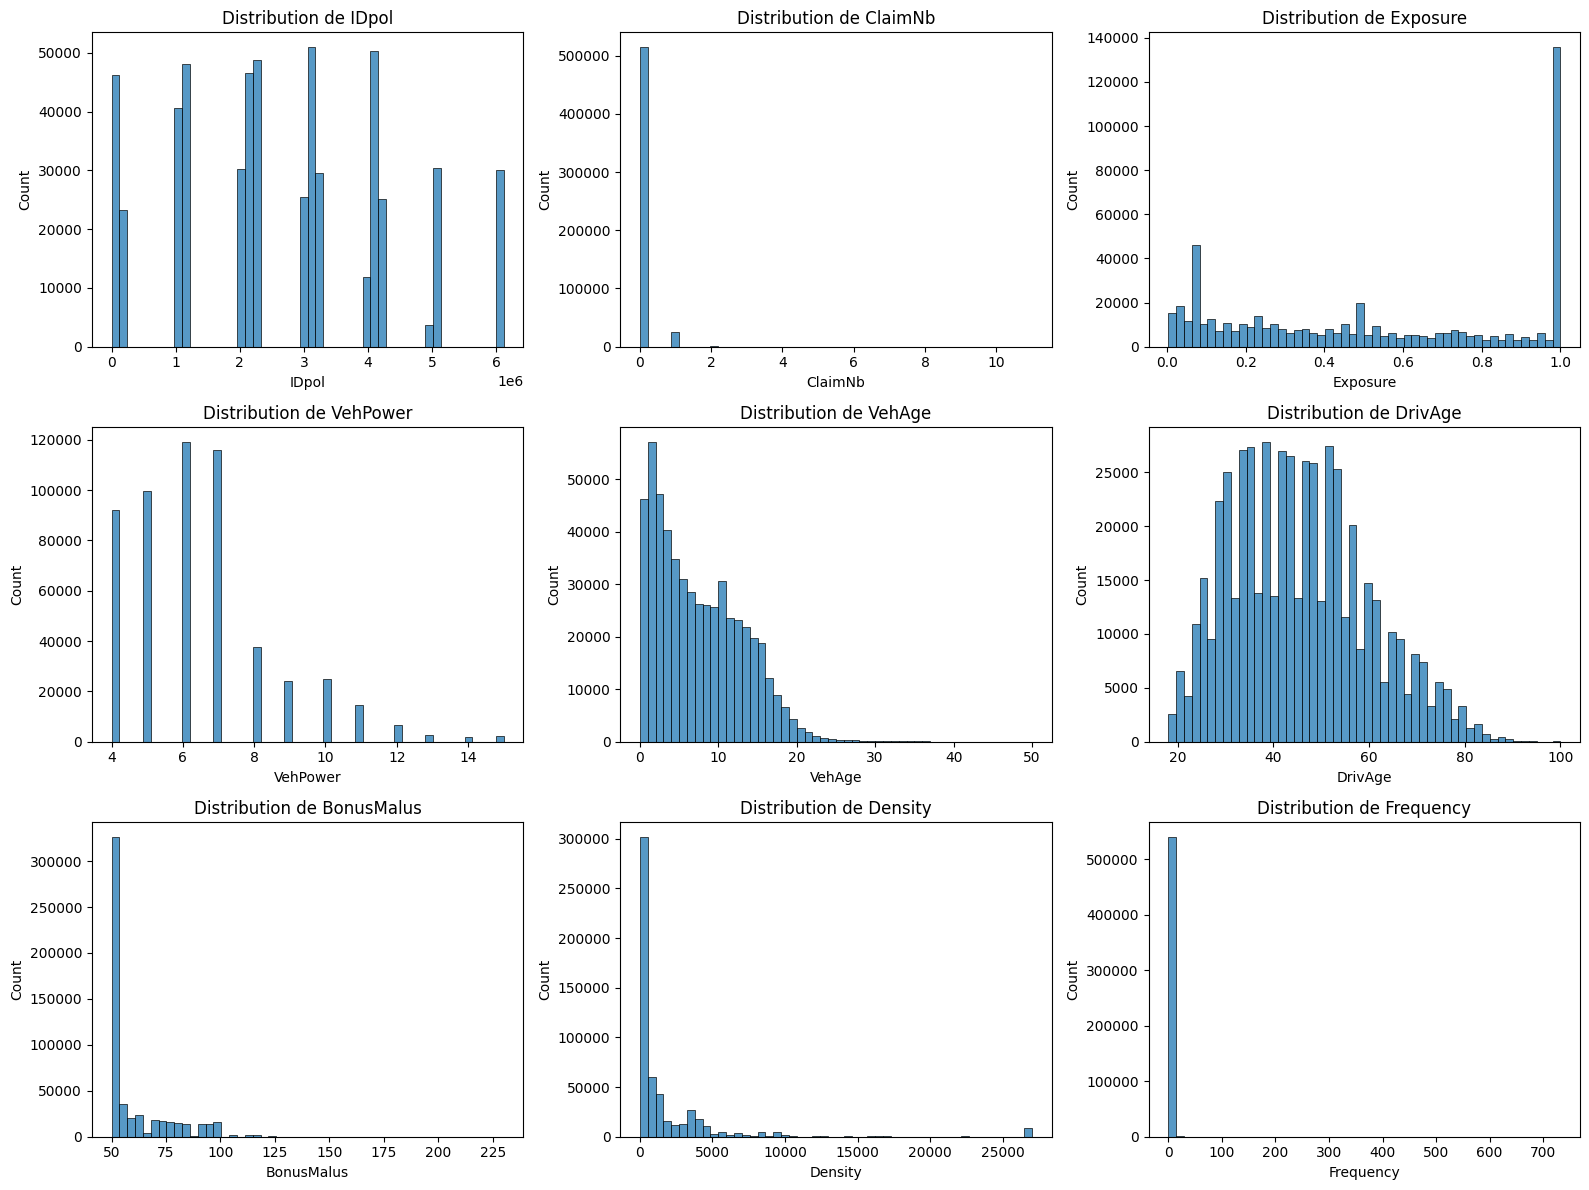

In [49]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.histplot(df_train_freq[col], bins=50, ax=axes[i])
    axes[i].set_title(f'Distribution de {col}')

plt.tight_layout()
plt.show()

Représentation graphique des différents quartiles des variables explicatives.

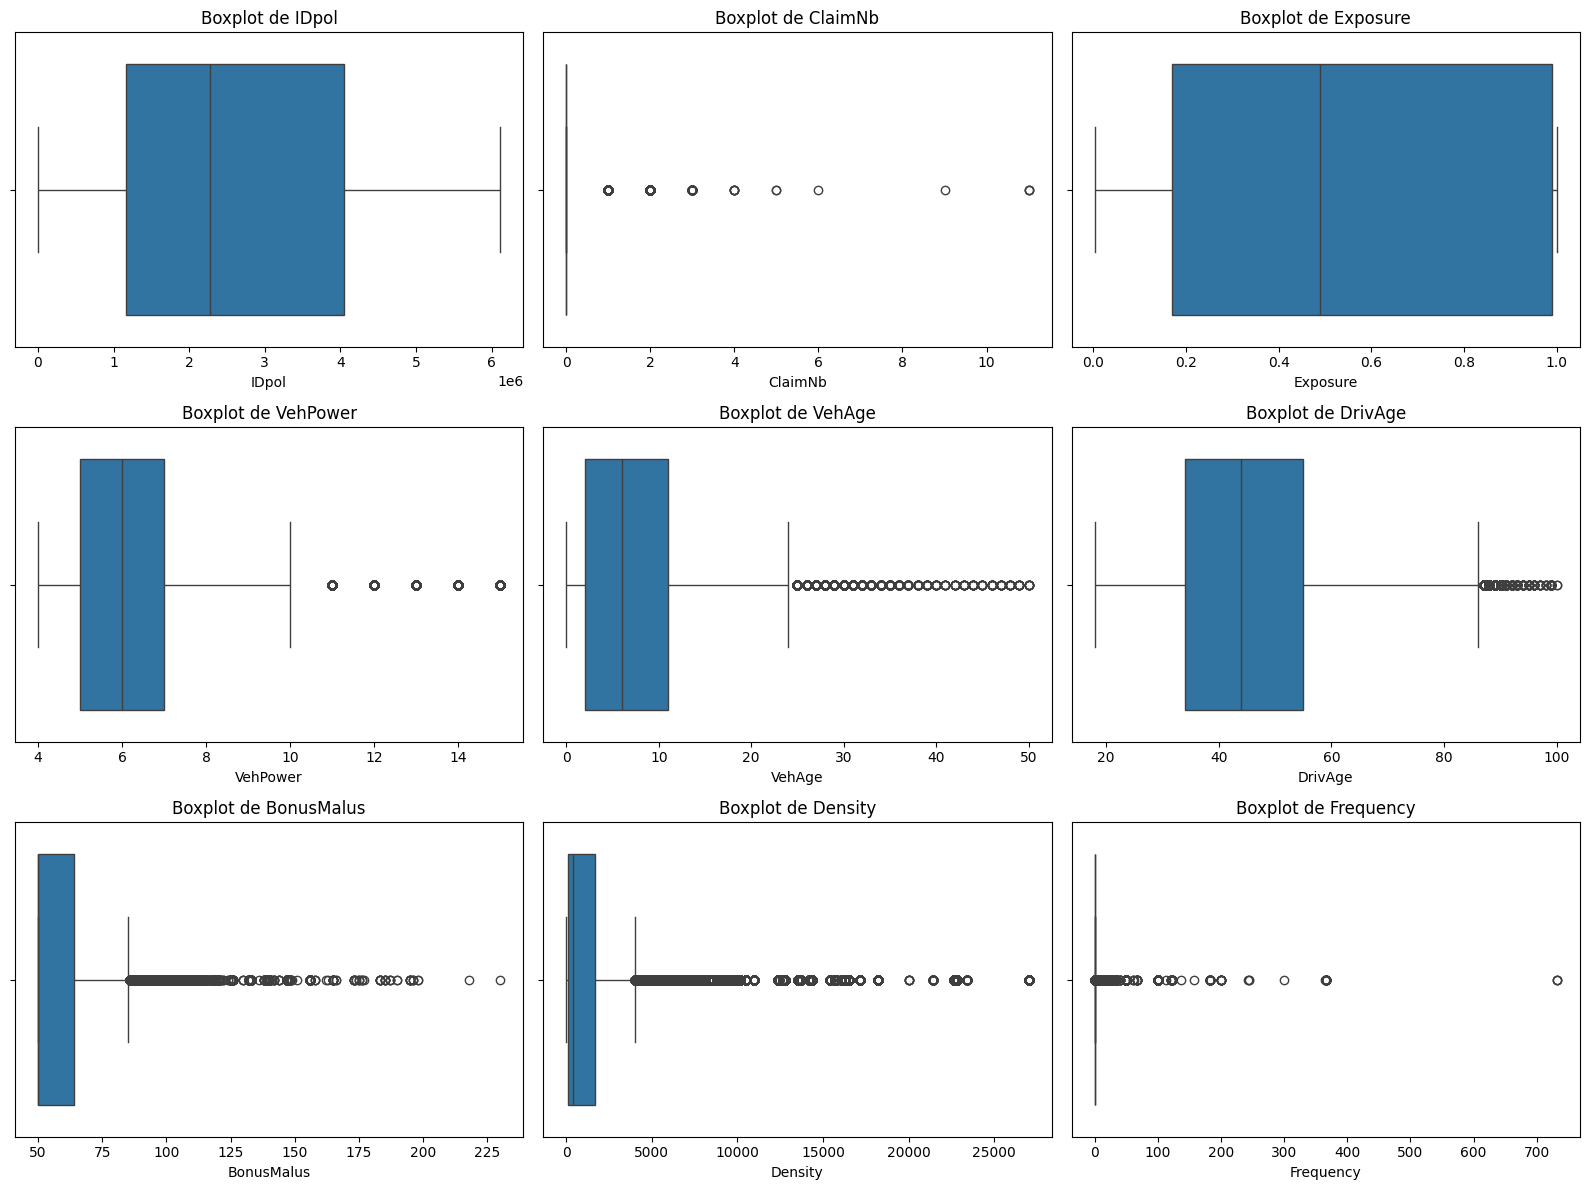

In [50]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df_train_freq[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()

Effectuons un test de surdispersion pour choisir le modèle le plus adapté pour l'estimation de la fréquence.

In [51]:
mean_claims = df_train_freq['ClaimNb'].mean()
var_claims = df_train_freq['ClaimNb'].var()
print(f"Ratio variance/moyenne : {var_claims/mean_claims:.3f}")

print(df_train_freq['ClaimNb'].value_counts().sort_index())
print(f"% avec 1 sinistre : {(df_train_freq['ClaimNb']==1).mean():.2%}")
print(f"% avec 2+ sinistres : {(df_train_freq['ClaimNb']>=2).mean():.2%}")

Ratio variance/moyenne : 1.077
ClaimNb
0     514148
1      25709
2       1421
3         63
4          5
5          2
6          1
9          1
11         3
Name: count, dtype: int64
% avec 1 sinistre : 4.75%
% avec 2+ sinistres : 0.28%


Par leur faible nombre, analysons les profils avec 4 réclamations ou plus.

In [52]:
extreme_cases = df_train_freq[df_train_freq['ClaimNb'] >= 4]
print(f"Contrats avec 6+ sinistres :")
print(f"  Nombre de contrats : {len(extreme_cases)}")


print(f"\nDÉTAIL DES CONTRATS AVEC 4+ SINISTRES :")
print(extreme_cases[['IDpol', 'ClaimNb', 'Exposure', 'DrivAge', 'VehAge', 'VehPower', 'BonusMalus']])

print(f"\nFRÉQUENCES :")
extreme_cases_copy = extreme_cases.copy()
extreme_cases_copy['FreqAnnualisee'] = extreme_cases_copy['ClaimNb'] / extreme_cases_copy['Exposure']
print(extreme_cases_copy[['IDpol', 'ClaimNb', 'Exposure', 'FreqAnnualisee']].sort_values('FreqAnnualisee', ascending=False))

Contrats avec 6+ sinistres :
  Nombre de contrats : 12

DÉTAIL DES CONTRATS AVEC 4+ SINISTRES :
            IDpol  ClaimNb  Exposure  DrivAge  VehAge  VehPower  BonusMalus
500682  4031494.0        4      0.10       31       1         4          85
9136      24495.0        4      1.00       50       2         7          50
486962  3254353.0       11      0.07       53      13         4          50
320469  2248174.0        9      0.08       52      12         4          50
6539      19471.0       11      1.00       65       6         5          50
485960  3253234.0       11      0.08       53      13         4          50
551        1147.0        4      0.08       42       0         5          51
363147  3016883.0        4      0.27       23       9         5          90
303452  2216294.0        6      0.33       52      12         4          50
654044  6059824.0        4      0.57       48       2         5          64
46457     93954.0        5      1.00       67       9         7     

On peut supprimer les sinistres avec une fréquence supérieure ou égale à 40 sinistres par an car ce sont des baleurs aberrantes, lesautres sont des cas extrêmes mais reste plausible.

### 3.5 Analyse bivariée

Traitement de la variable : DrivAge


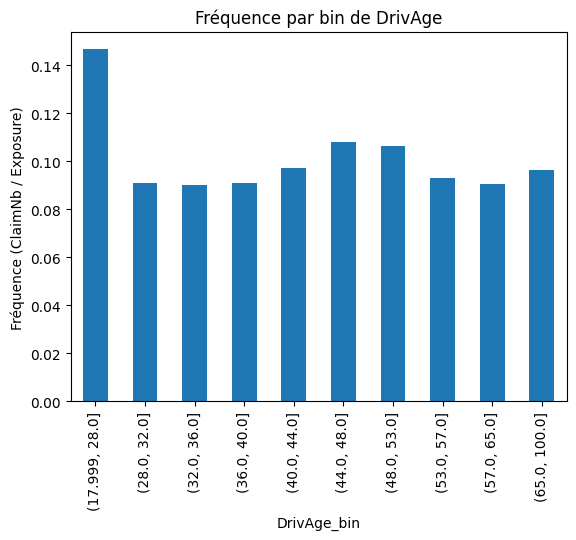

Traitement de la variable : VehAge


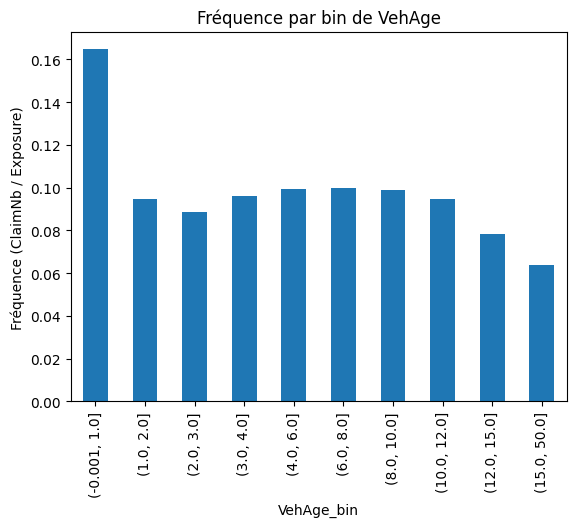

Traitement de la variable : VehPower


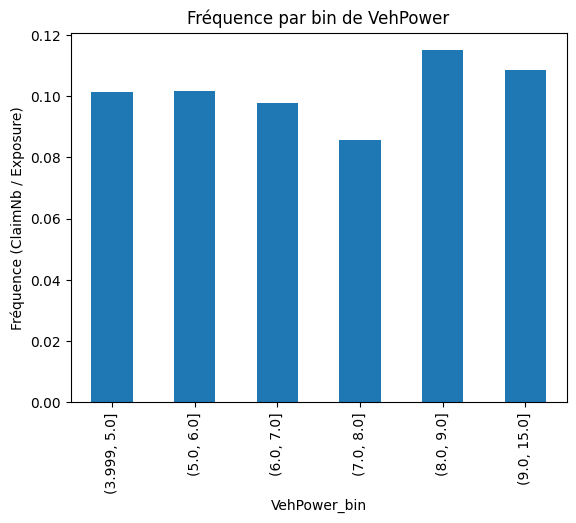

Traitement de la variable : Density


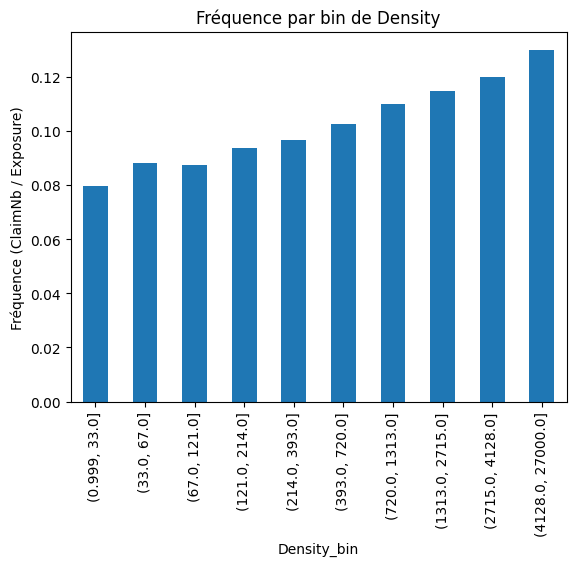

Traitement de la variable : BonusMalus


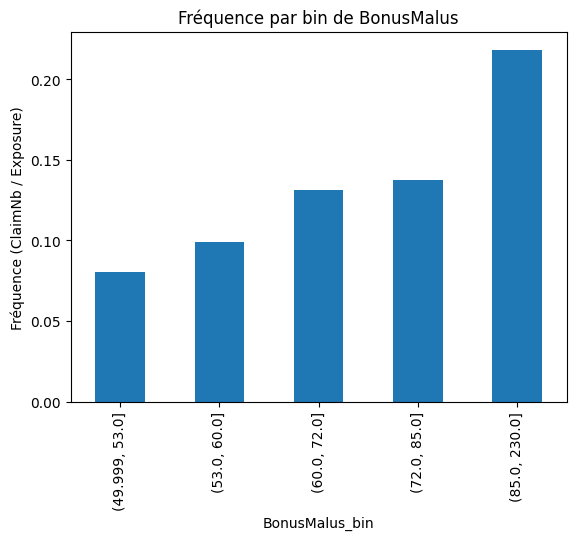

In [53]:
def bin_and_plot_multiple(df, cols, bins=10):
    for col in cols:
        print(f"Traitement de la variable : {col}")
        
        df_copy = df.copy() 
        
        df_copy[f"{col}_bin"] = pd.qcut(df_copy[col], q=bins, duplicates='drop')
        
        grouped = df_copy.groupby(f"{col}_bin", observed=False).agg(
            ClaimNb_sum = ('ClaimNb', 'sum'),
            Exposure_sum = ('Exposure', 'sum')
        )
        
        grouped['Freq'] = grouped['ClaimNb_sum'] / grouped['Exposure_sum']
        grouped['Freq'].plot(kind='bar')
        plt.title(f"Fréquence par bin de {col}")
        plt.ylabel("Fréquence (ClaimNb / Exposure)")
        plt.show()
variables = ['DrivAge', 'VehAge', 'VehPower', 'Density', 'BonusMalus']
bin_and_plot_multiple(df_train_freq, variables)

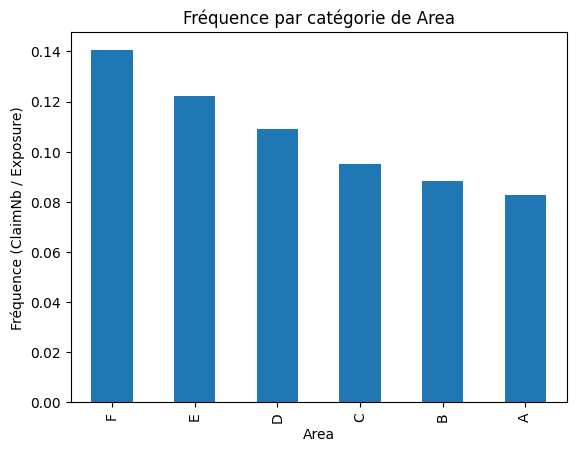

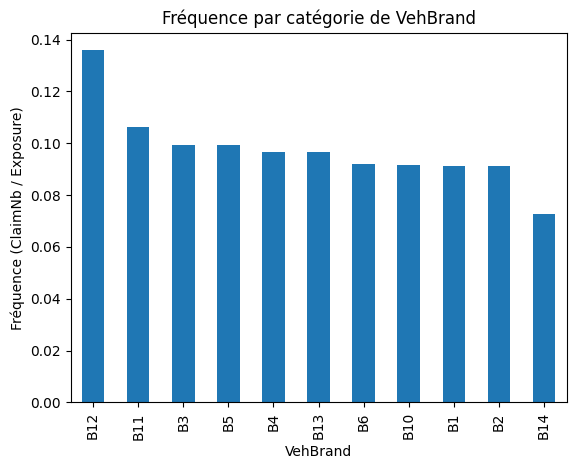

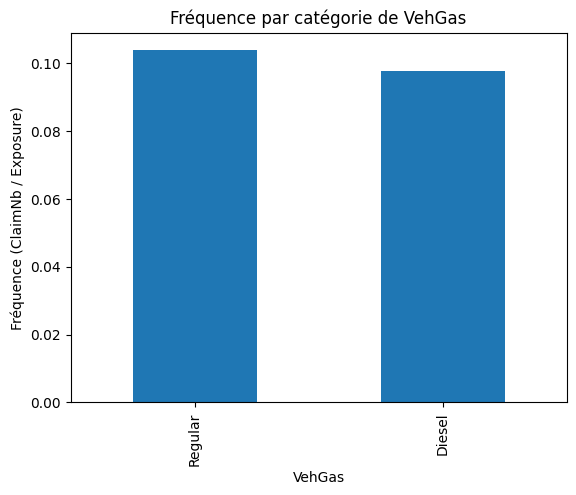

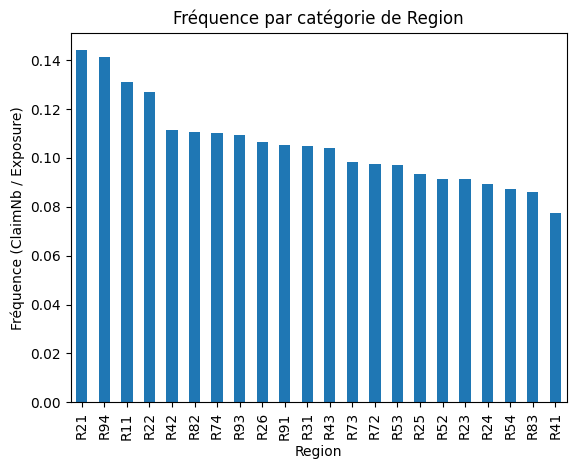

In [54]:
cat_cols = df_train_freq.select_dtypes(include='object').columns

def cat_var_freq(df, col):
    grouped = df.groupby(col).agg(
        ClaimNb_sum = ('ClaimNb', 'sum'),
        Exposure_sum = ('Exposure', 'sum')
    )
    grouped['Freq'] = grouped['ClaimNb_sum'] / grouped['Exposure_sum']
    grouped = grouped.sort_values(by='Freq', ascending=False)
    grouped['Freq'].plot(kind='bar')
    plt.title(f"Fréquence par catégorie de {col}")
    plt.ylabel("Fréquence (ClaimNb / Exposure)")
    plt.show()

for col in cat_cols:
    cat_var_freq(df_train_freq, col)

On voit clairement que la zone, la marque du vehicule, et la région ont un réel impact sur la fréquence, on va donc premièrement regarder matrice de corrélation sans encodage puis avec encodage.

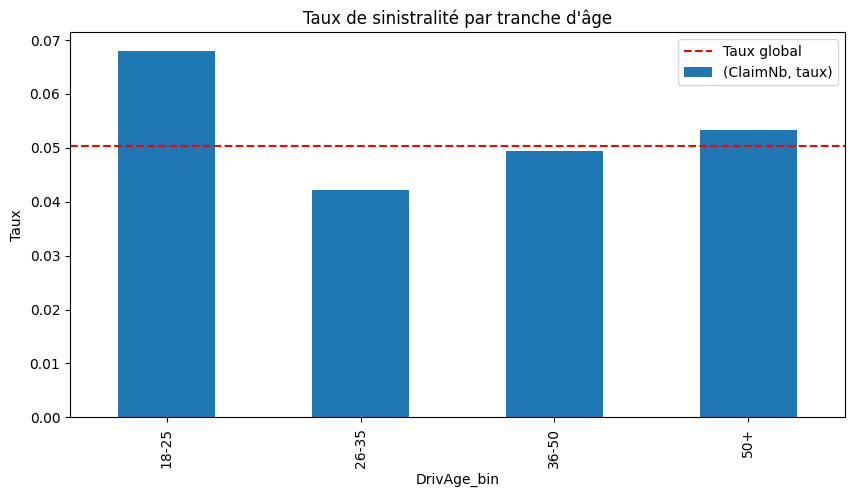

In [55]:
df_train_freq['DrivAge_bin'] = pd.cut(df_train_freq['DrivAge'], bins=[0,25,35,50,100],
                                  labels=['18-25', '26-35', '36-50', '50+'])
rate_by_age = df_train_freq.groupby('DrivAge_bin', observed=True).agg({
    'ClaimNb': [('taux', lambda x: (x>0).mean())]
})

rate_by_age.plot(kind='bar', figsize=(10, 5))
plt.title('Taux de sinistralité par tranche d\'âge')
plt.ylabel('Taux')
plt.axhline((df_train_freq['ClaimNb']>0).mean(), color='red', linestyle='--', label='Taux global')
plt.legend()
plt.show()

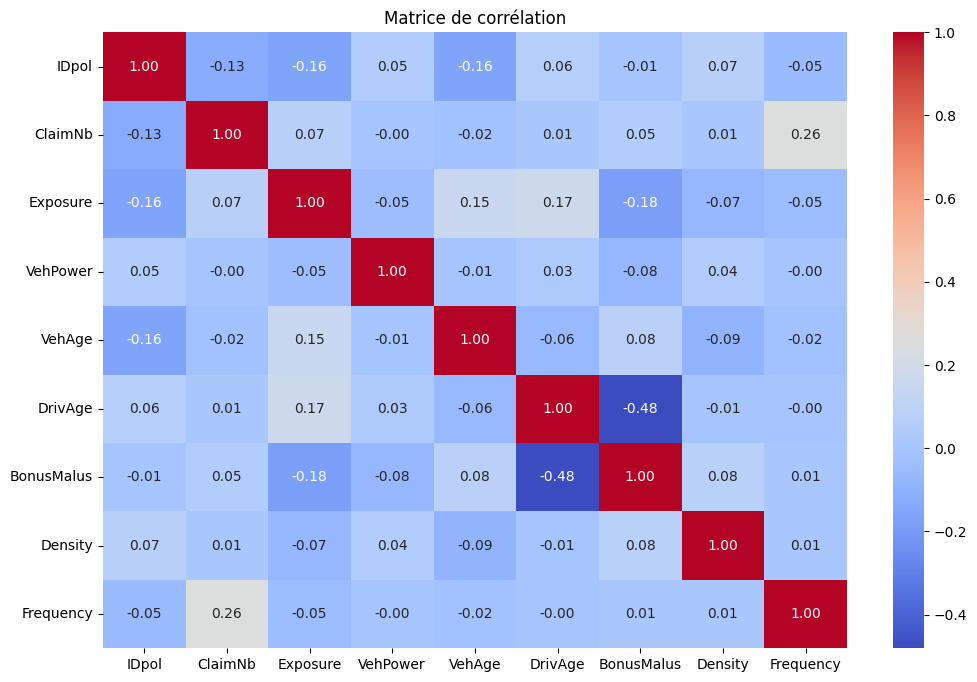

In [56]:
# Effectuer matrice de corrélation parmi colonnes numériques
num_cols = df_train_freq.select_dtypes(include='number').columns
corr_matrix = df_train_freq[num_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()


## 4. EDA Sévérité

Commençons par créer le dataset qui nous servira pour notre EDA sur la sévérité.

In [57]:
df_train_sev = df_train[df_train['ClaimNb'] > 0].copy()

print(f"df_train : {df_train.shape}")
print(f"df_train_sev : {df_train_sev.shape}")

df_train : (541353, 15)
df_train_sev : (27205, 15)


### 4.1 Contrôle qualité des données

Vérification des premières lignes de notre dataset.

In [58]:
df_train_sev.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Severity,Frequency
533952,4126439.0,3,0.77,E,5,15,62,60,B2,Diesel,3095,R31,3612.00,1204.00,3.896104
250490,2104637.0,1,0.36,F,5,6,35,50,B1,Regular,27000,R11,2566.71,2566.71,2.777778
134960,1094963.0,1,1.00,C,10,6,45,50,B2,Regular,313,R25,206.65,206.65,1.000000
13744,32867.0,1,0.84,F,6,2,29,95,B2,Diesel,15703,R11,1163.61,1163.61,1.190476
50919,103423.0,1,0.60,C,5,0,63,50,B2,Diesel,153,R41,75.68,75.68,1.666667


Analyse des statistiques descriptives

In [59]:
df_train_sev.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,Severity,Frequency
count,2.720500e+04,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000
mean,1.658593e+06,1.059291,0.640730,6.417166,6.487815,46.258482,63.123507,1971.831869,1533.650634,1426.250873,5.290156
std,1.680892e+06,0.274067,0.342063,1.994650,5.289117,14.890983,18.994815,4272.925110,7711.826495,6994.024235,20.257718
min,1.000000e+00,1.000000,0.002732,4.000000,0.000000,18.000000,50.000000,2.000000,0.000000,0.000000,1.000000
25%,2.320600e+04,1.000000,0.330000,5.000000,2.000000,35.000000,50.000000,100.000000,0.000000,0.000000,1.000000
50%,1.133699e+06,1.000000,0.710000,6.000000,6.000000,46.000000,50.000000,442.000000,1128.000000,1008.490000,1.515152
75%,3.088999e+06,1.000000,1.000000,7.000000,10.000000,55.000000,72.000000,1955.000000,1204.000000,1204.000000,3.157895
max,6.113971e+06,11.000000,1.000000,15.000000,39.000000,99.000000,196.000000,27000.000000,399213.660000,307096.420000,732.000000


Vérification présence valeurs manquantes.

In [60]:
df_train_sev.isnull().sum()

IDpol          0
ClaimNb        0
Exposure       0
Area           0
VehPower       0
VehAge         0
DrivAge        0
BonusMalus     0
VehBrand       0
VehGas         0
Density        0
Region         0
ClaimAmount    0
Severity       0
Frequency      0
dtype: int64

Il ne manque pas de valeurs, cherchons maintenant la présence de valeurs dupliquées

In [61]:
df_train_sev.duplicated().sum()

np.int64(0)

### 4.2 Analyse univariée

Analysons les statistiques descriptives du dataset.

In [62]:
df_train_sev.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,Severity,Frequency
count,2.720500e+04,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000,27205.000000
mean,1.658593e+06,1.059291,0.640730,6.417166,6.487815,46.258482,63.123507,1971.831869,1533.650634,1426.250873,5.290156
std,1.680892e+06,0.274067,0.342063,1.994650,5.289117,14.890983,18.994815,4272.925110,7711.826495,6994.024235,20.257718
min,1.000000e+00,1.000000,0.002732,4.000000,0.000000,18.000000,50.000000,2.000000,0.000000,0.000000,1.000000
1%,7.141200e+02,1.000000,0.010400,4.000000,0.000000,20.000000,50.000000,10.000000,0.000000,0.000000,1.000000
5%,3.474600e+03,1.000000,0.060000,4.000000,0.000000,23.000000,50.000000,21.000000,0.000000,0.000000,1.000000
25%,2.320600e+04,1.000000,0.330000,5.000000,2.000000,35.000000,50.000000,100.000000,0.000000,0.000000,1.000000
50%,1.133699e+06,1.000000,0.710000,6.000000,6.000000,46.000000,50.000000,442.000000,1128.000000,1008.490000,1.515152
75%,3.088999e+06,1.000000,1.000000,7.000000,10.000000,55.000000,72.000000,1955.000000,1204.000000,1204.000000,3.157895
95%,4.188354e+06,2.000000,1.000000,10.000000,16.000000,73.000000,100.000000,8455.000000,3903.882000,3622.694000,16.666667


Calculons la sévérité moyenne globale, cette information nous sera utile lors de l'entraînement de nos modèles.

In [63]:
avg_severity = df_train_sev["ClaimAmount"].sum() / df_train_sev["ClaimAmount"].count()

print(f"Sévérité moyenne globale : {avg_severity:.2f} €")

Sévérité moyenne globale : 1533.65 €


Effectuons désormais des histplots de nos variables numériques pour observer leurs distributions.

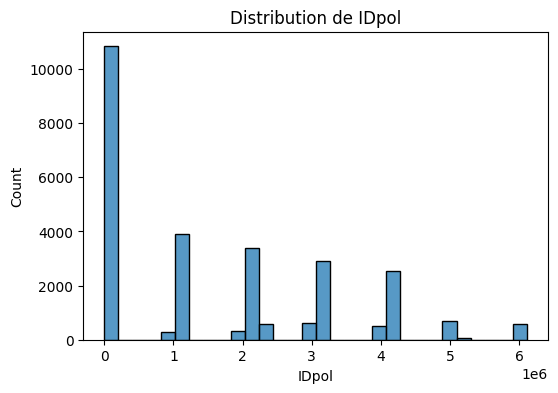

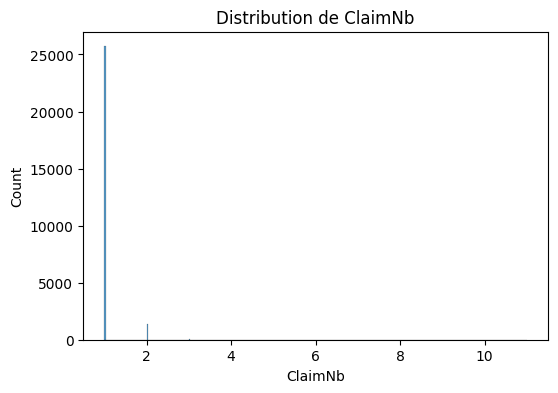

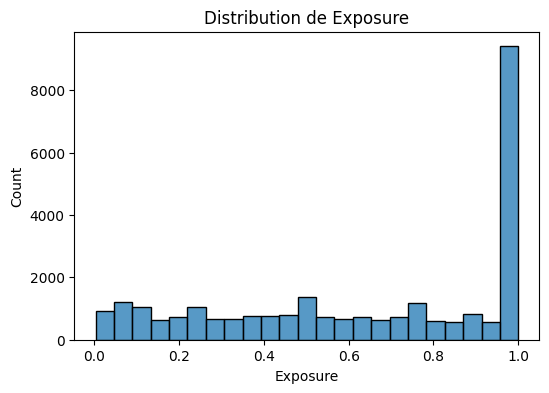

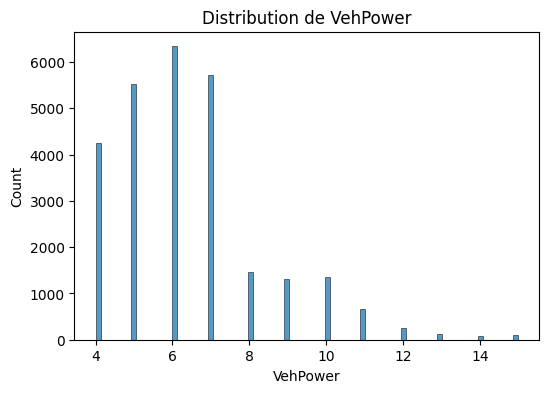

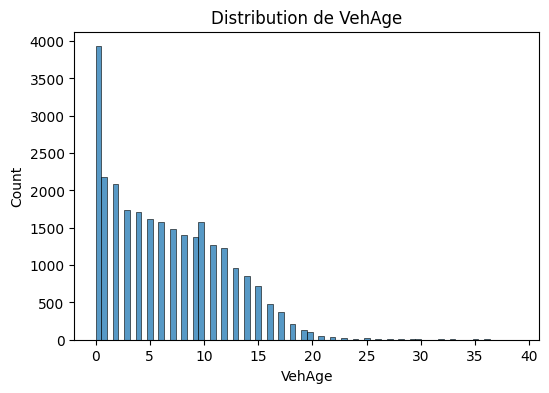

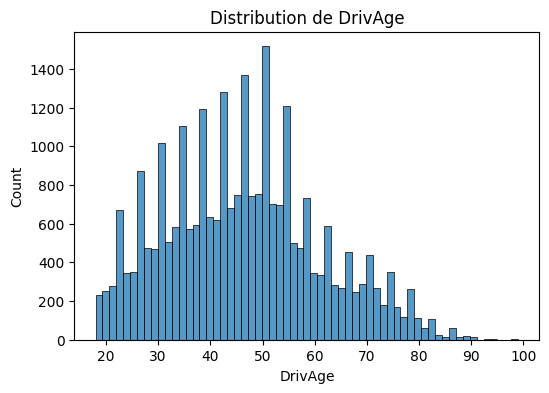

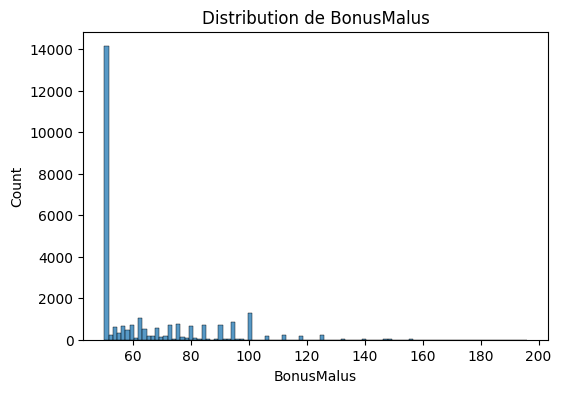

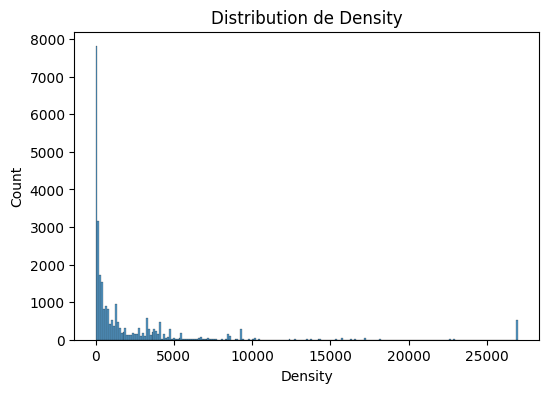

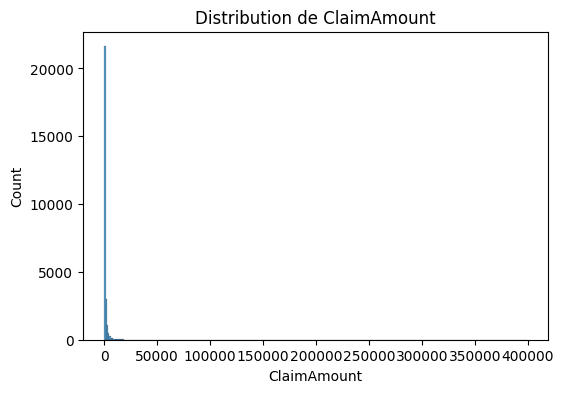

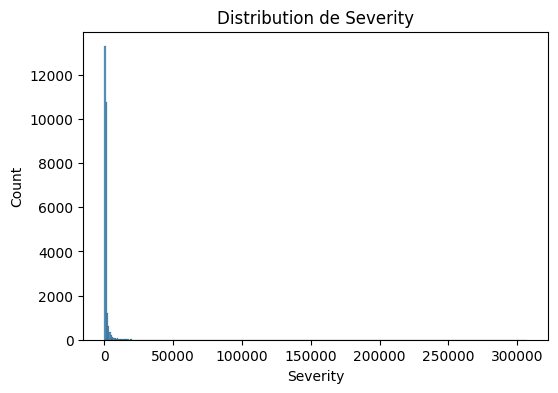

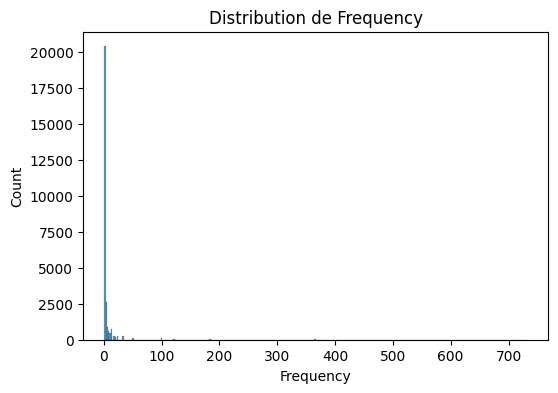

In [64]:
num_cols = df_train_sev.select_dtypes(include='number').columns

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_train_sev[col])
    plt.title(f'Distribution de {col}')
    plt.show()

On constate que la répartition de nos données est biaisée par la grande quantitée de 0 sur de nombreuses variables, il est préférable de les passer au logarithme pour obtenir un meilleur aperçu de leur distribution.

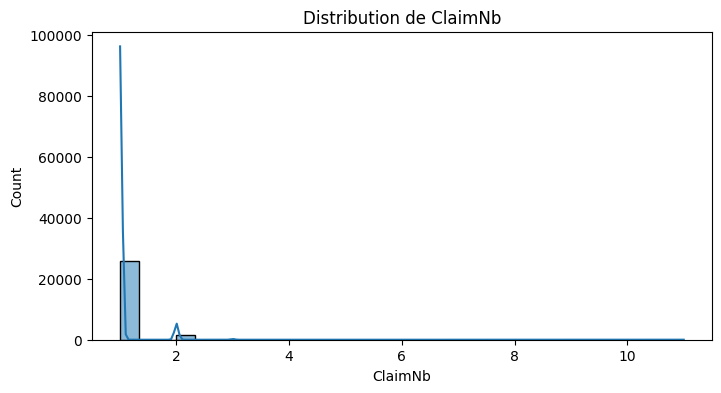

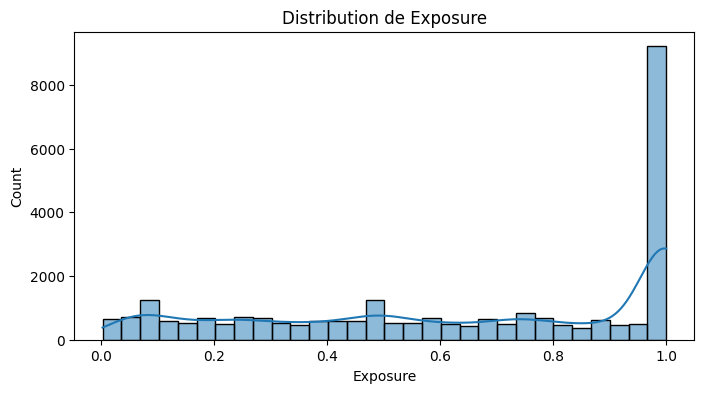

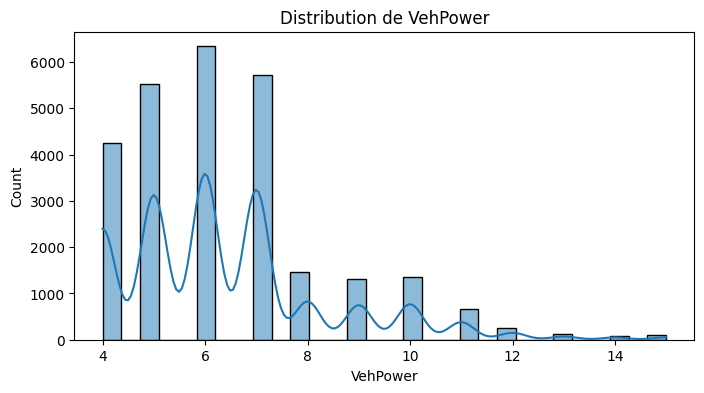

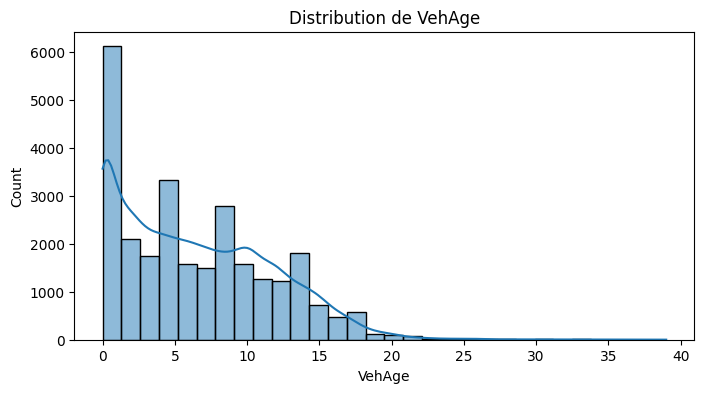

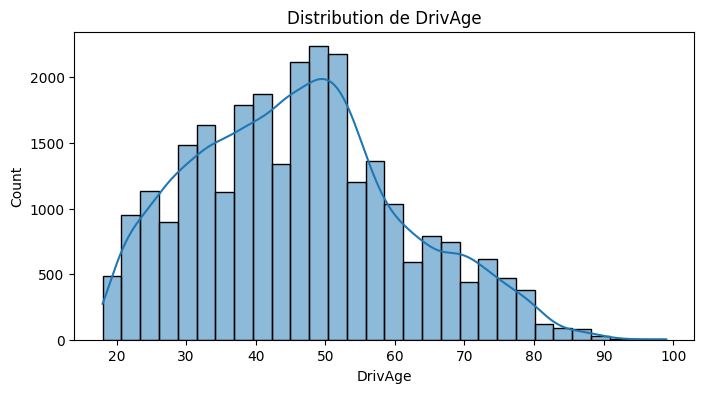

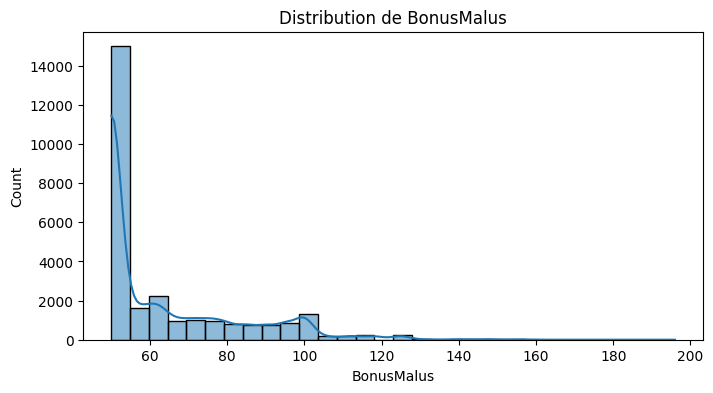

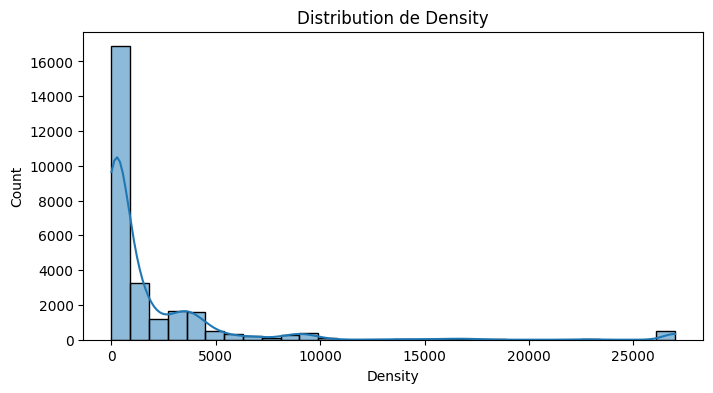

C:\Users\lucas\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


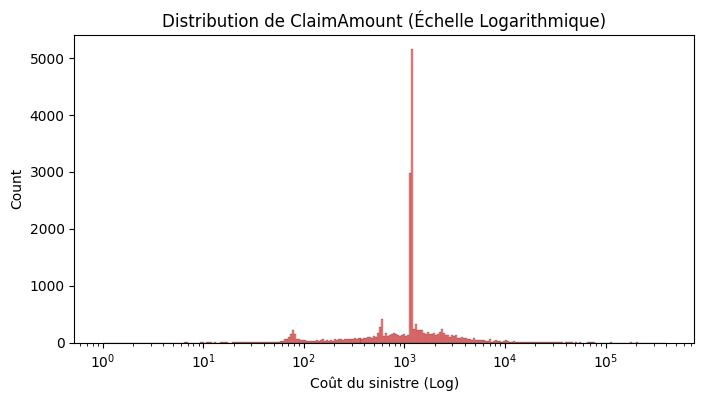

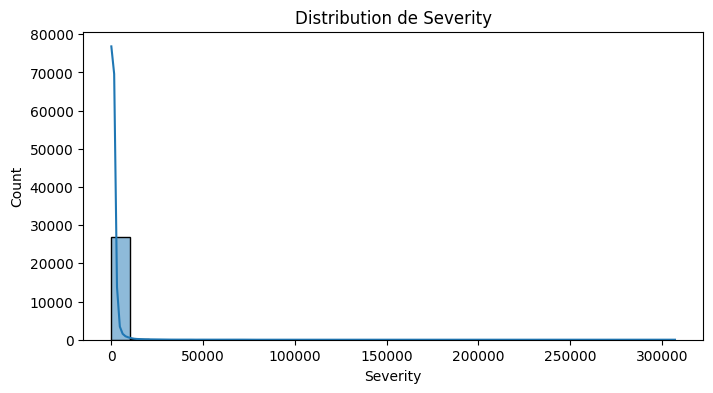

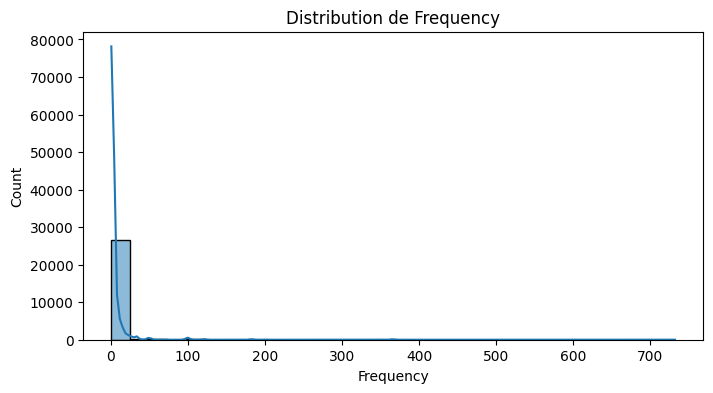

In [65]:
cols_to_plot = [col for col in df_train_sev.select_dtypes(include='number').columns if col != 'IDpol']

for col in cols_to_plot:
    plt.figure(figsize=(8, 4))
    if col == 'ClaimAmount':
        sns.histplot(df_train_sev[col], log_scale=True, kde=True, color='red')
        plt.title(f'Distribution de {col} (Échelle Logarithmique)')
        plt.xlabel('Coût du sinistre (Log)')
    else:
        sns.histplot(df_train_sev[col], kde=True, bins=30)
        plt.title(f'Distribution de {col}')
        
    plt.show()

Ce choix de représentatin graphique pour les réclamations ne semble pas le plus idéal, passons la distribution au log pour en obtenir un meilleur aperçu.

Text(0.5, 1.0, 'Distribution log(1 + ClaimAmount)')

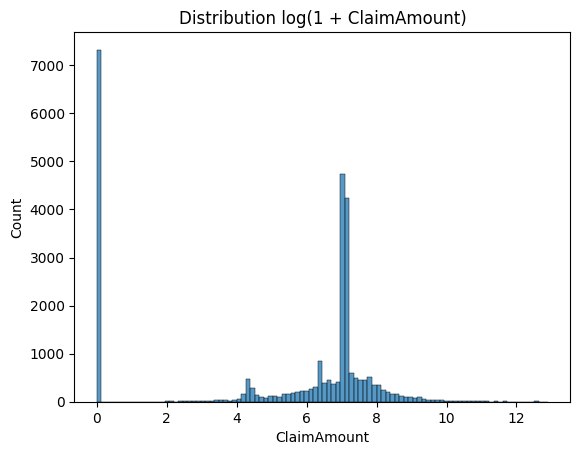

In [66]:
sns.histplot(np.log1p(df_train_sev['ClaimAmount']), bins=100)
plt.title("Distribution log(1 + ClaimAmount)")

Notre représentation graphique est largement plus visible, on voit donc que la majorité des réclamations se situent autour de 7, sur une échelle passée au log, regardons désormais la moyenne,la médiane et les valeurs par quantile de la feature.

In [67]:
print("Sévérité moyenne :", df_train_sev["ClaimAmount"].mean())
print("Sévérité médiane :", df_train_sev["ClaimAmount"].median())
print("Quantiles :", df_train_sev["ClaimAmount"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))

Sévérité moyenne : 1533.6506344421982
Sévérité médiane : 1128.0
Quantiles : 0.50     1128.0000
0.75     1204.0000
0.90     2382.6280
0.95     3903.8820
0.99    13797.6152
Name: ClaimAmount, dtype: float64


### 4.4 Analyse bivariée

Etudions les relations entre les différentes variables explcatives et notre variable cible (`Severity`)

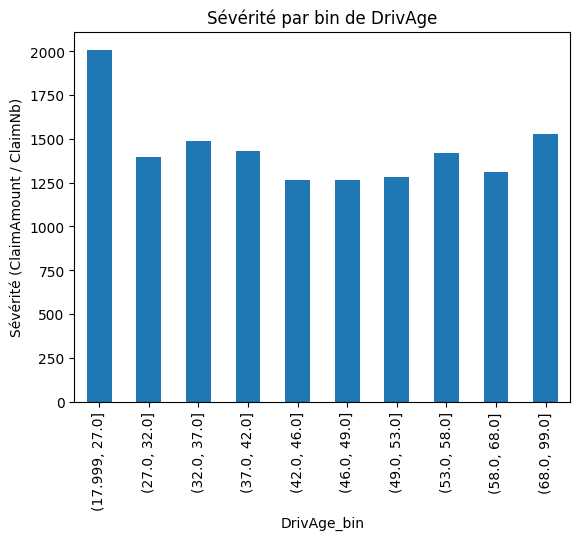

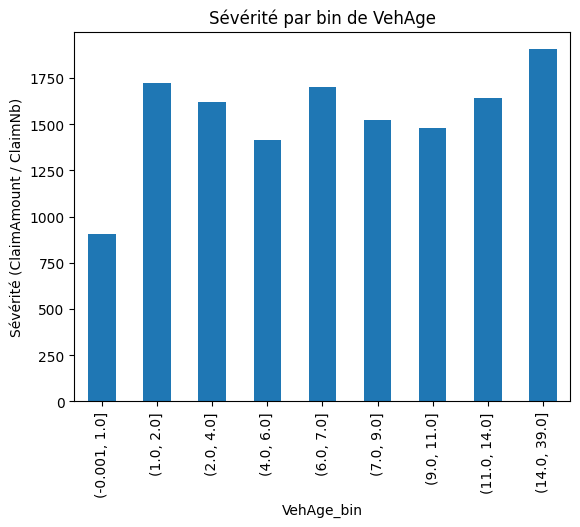

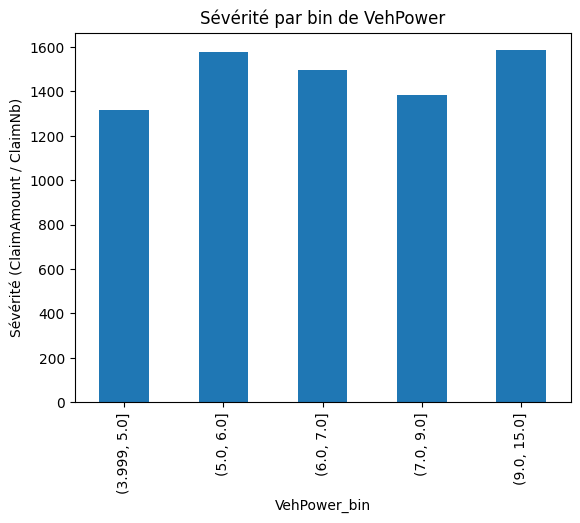

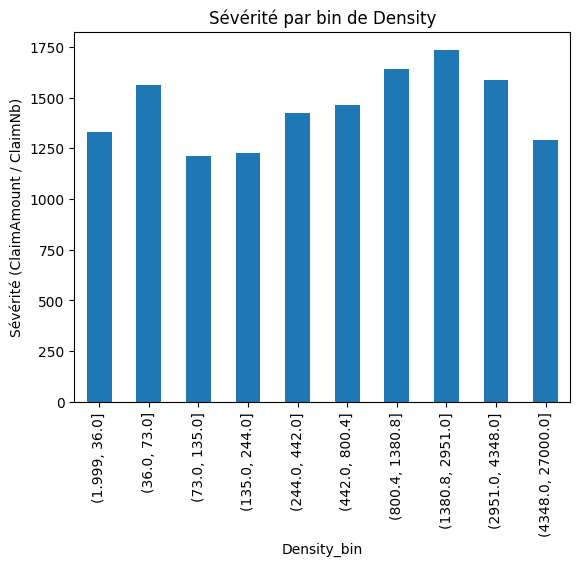

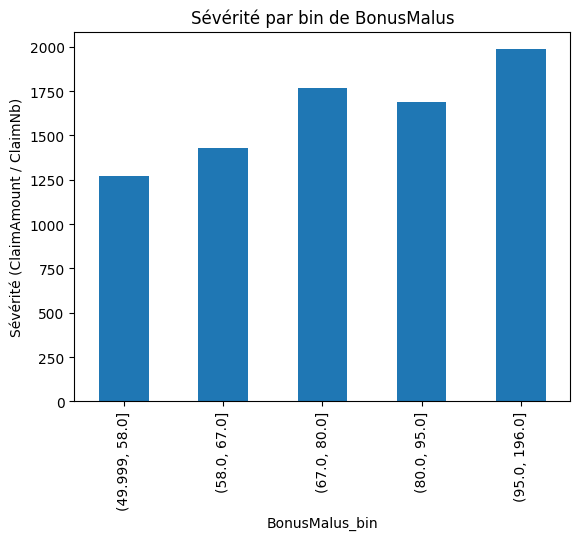

In [68]:
def bin_and_plot_multiple(df, cols, bins=10):
    for col in cols:
        df_train_sev_copy = df_train_sev.copy() 
        
        df_train_sev_copy[f"{col}_bin"] = pd.qcut(df_train_sev_copy[col], q=bins, duplicates='drop')
        
        grouped = df_train_sev_copy.groupby(f"{col}_bin", observed=False).agg(
            ClaimNb_sum = ('ClaimNb', 'sum'),
            ClaimAmount_sum = ('ClaimAmount', 'sum')
        )
        
        grouped['Sev'] = grouped['ClaimAmount_sum'] / grouped['ClaimNb_sum']
        grouped['Sev'].plot(kind='bar')
        plt.title(f"Sévérité par bin de {col}")
        plt.ylabel("Sévérité (ClaimAmount / ClaimNb)")
        plt.show()
variables = ['DrivAge', 'VehAge', 'VehPower', 'Density', 'BonusMalus']
bin_and_plot_multiple(df_train_sev, variables)

On observe que pour chaque variables numériques, il y a bien un lien avec la sévérité du sinistre, en particulier pour DrivAge et VehPower. Passons désormais aux variables catégorielles:

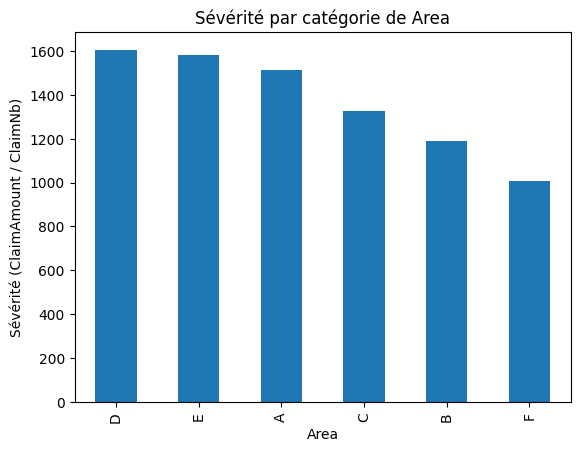

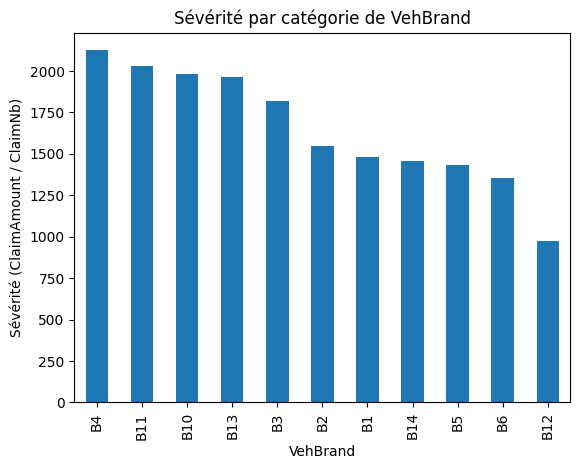

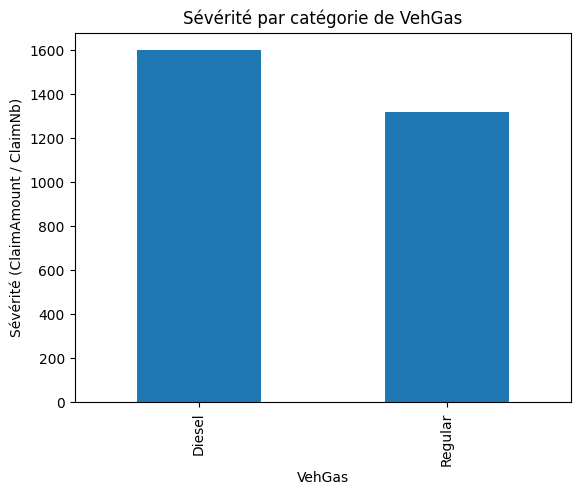

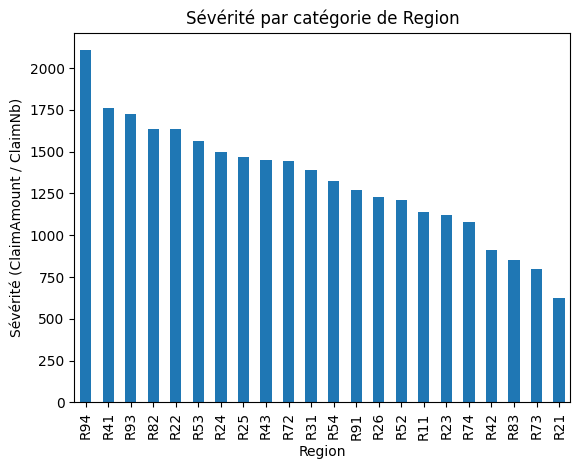

In [69]:
cat_cols = df_train_sev.select_dtypes(include='object').columns

def cat_var_train_sev(df, col):
    grouped = df.groupby(col).agg(
        ClaimNb_sum = ('ClaimNb', 'sum'),
        ClaimAmount_sum = ('ClaimAmount', 'sum')
    )
    grouped['Sev'] = grouped['ClaimAmount_sum'] / grouped['ClaimNb_sum']
    grouped = grouped.sort_values(by='Sev', ascending=False)
    grouped['Sev'].plot(kind='bar')
    plt.title(f"Sévérité par catégorie de {col}")
    plt.ylabel("Sévérité (ClaimAmount / ClaimNb)")
    plt.show()

for col in cat_cols:
    cat_var_train_sev(df_train_sev, col)

Encore une fois, il existe un lien entre nos features catégorielles et la sévérité, cependant, il est moins marqué qu'avec certaines de nos variables numériques. Nous allons désormais effectuer une matrice de corrélation.

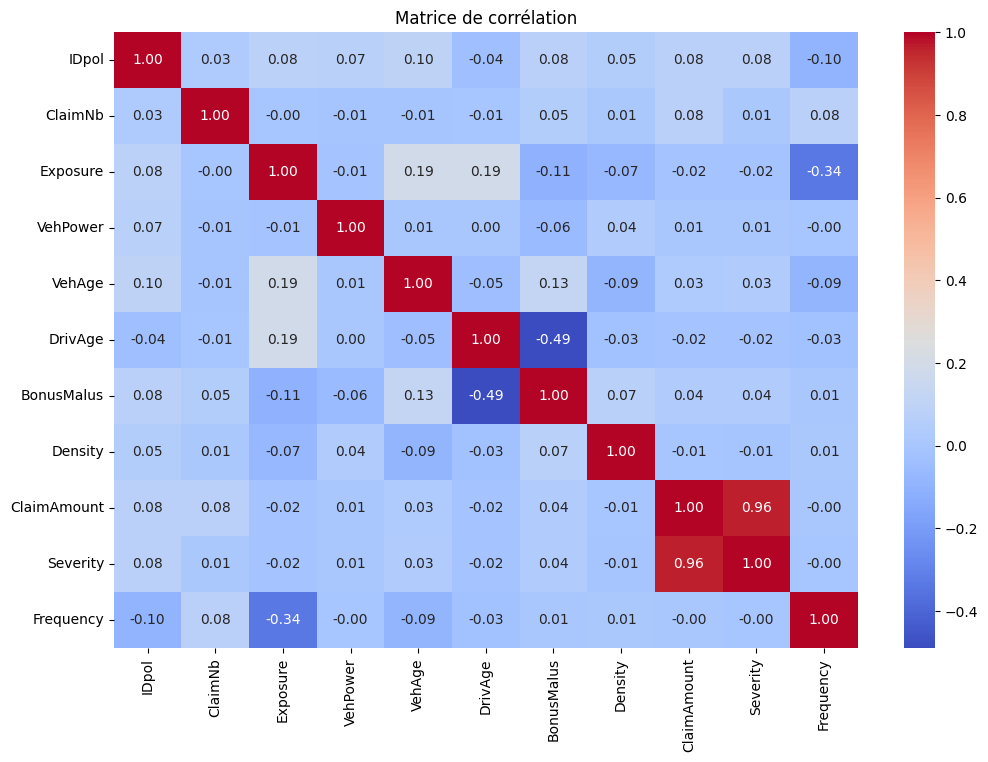

In [70]:
corr_matrix = df_train_sev[num_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()


Il ne semble pas exister de lien évident entre ClaimAmount et les autres features et ce résultat 

## 5. Analyse comparative Fréquence vs Sévérité

Réalisons une matrice de corrélation entre (`ClaimNb`) et  (`Severity`) pou vérifier si ils sont décorrélés

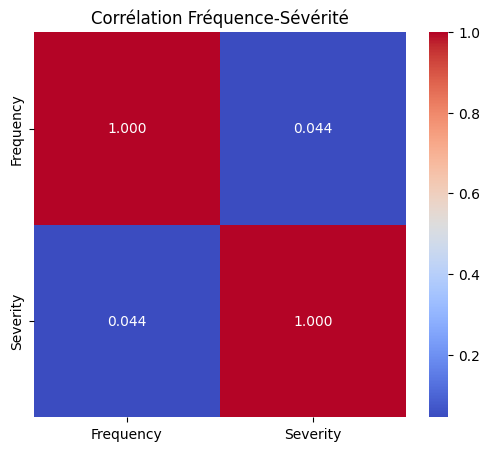

In [71]:
corr_matrix = df_train[['Frequency', 'Severity']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm')
plt.title("Corrélation Fréquence-Sévérité")
plt.show()

C:\Users\lucas\AppData\Local\Temp\ipykernel_18140\2259411226.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_by_bin = df_train_freq.groupby(bins).apply(
C:\Users\lucas\AppData\Local\Temp\ipykernel_18140\2259411226.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sev_by_bin = sev_data.groupby(pd.qcut(sev_data[var], q=5, duplicates='drop'))['Severity'].mean()


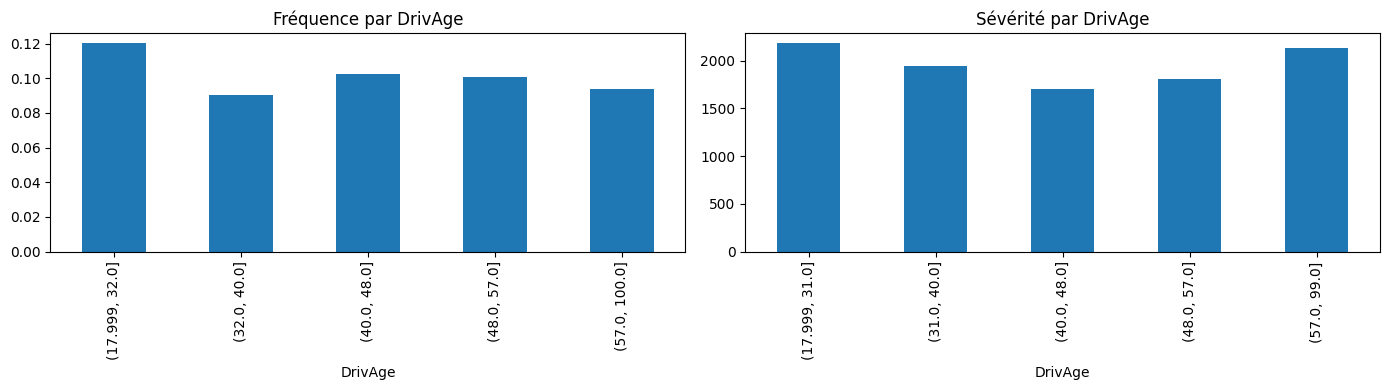

C:\Users\lucas\AppData\Local\Temp\ipykernel_18140\2259411226.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_by_bin = df_train_freq.groupby(bins).apply(
C:\Users\lucas\AppData\Local\Temp\ipykernel_18140\2259411226.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sev_by_bin = sev_data.groupby(pd.qcut(sev_data[var], q=5, duplicates='drop'))['Severity'].mean()


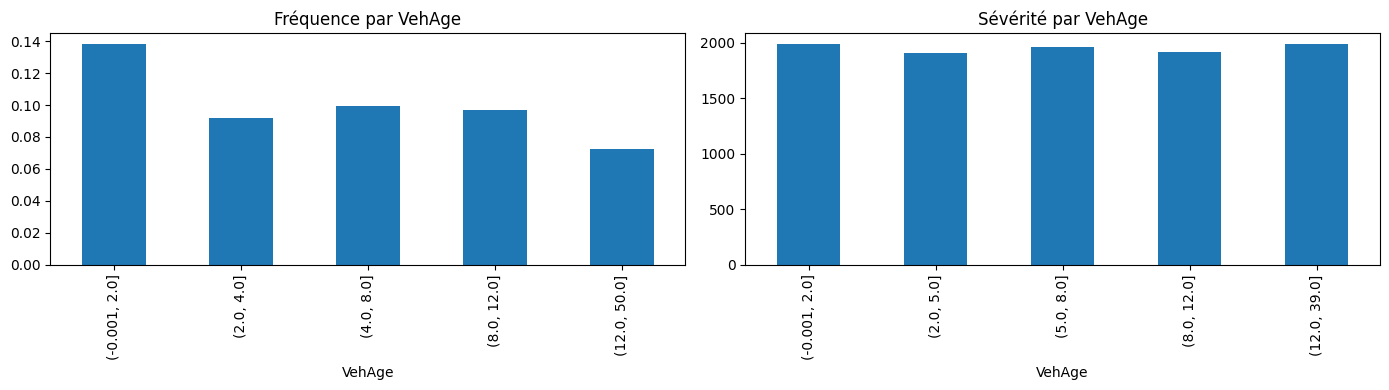

C:\Users\lucas\AppData\Local\Temp\ipykernel_18140\2259411226.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_by_bin = df_train_freq.groupby(bins).apply(
C:\Users\lucas\AppData\Local\Temp\ipykernel_18140\2259411226.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sev_by_bin = sev_data.groupby(pd.qcut(sev_data[var], q=5, duplicates='drop'))['Severity'].mean()


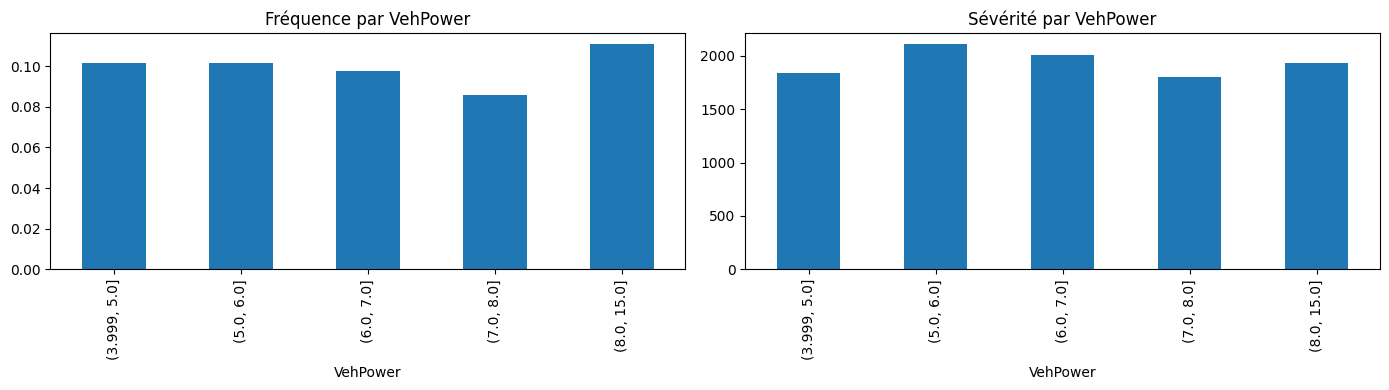

C:\Users\lucas\AppData\Local\Temp\ipykernel_18140\2259411226.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_by_bin = df_train_freq.groupby(bins).apply(
C:\Users\lucas\AppData\Local\Temp\ipykernel_18140\2259411226.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sev_by_bin = sev_data.groupby(pd.qcut(sev_data[var], q=5, duplicates='drop'))['Severity'].mean()


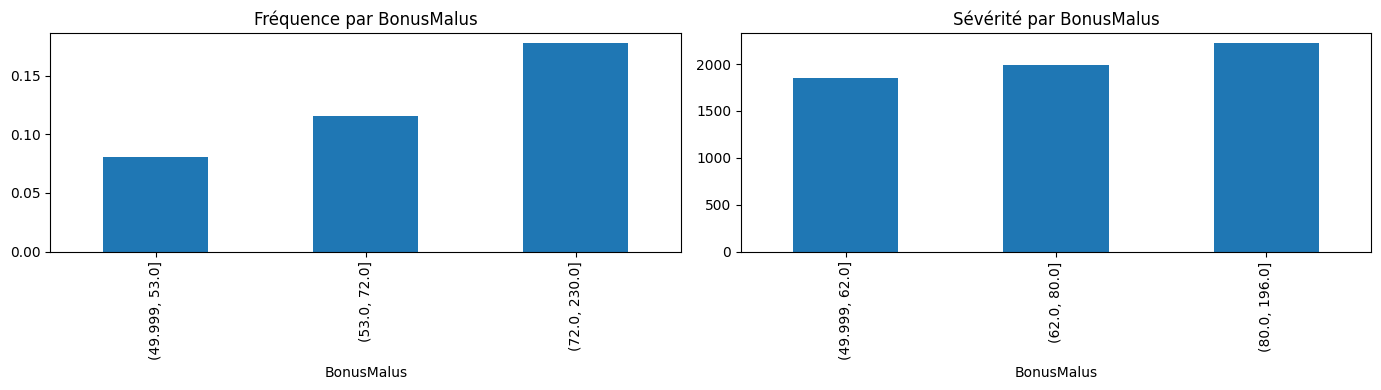

In [72]:
for var in ['DrivAge', 'VehAge', 'VehPower', 'BonusMalus']:
    bins = pd.qcut(df_train_freq[var], q=5, duplicates='drop')
    
    freq_by_bin = df_train_freq.groupby(bins).apply(
        lambda x: x['ClaimNb'].sum() / x['Exposure'].sum()
    )
    
    sev_data = df_train_sev[df_train_sev['Severity'] > 0]
    sev_by_bin = sev_data.groupby(pd.qcut(sev_data[var], q=5, duplicates='drop'))['Severity'].mean()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    freq_by_bin.plot(kind='bar', ax=ax1, title=f'Fréquence par {var}')
    sev_by_bin.plot(kind='bar', ax=ax2, title=f'Sévérité par {var}')
    plt.tight_layout()
    plt.show()

                        Nb_contrats  Frequence  Ratio_vs_Moy
Segment                                                     
Jeune + Puissant                374   0.238867      2.366954
Jeune + Normal                23937   0.191681      1.899386
Expérimenté + Puissant        27503   0.099362      0.984584
Standard                     489539   0.097491      0.966050


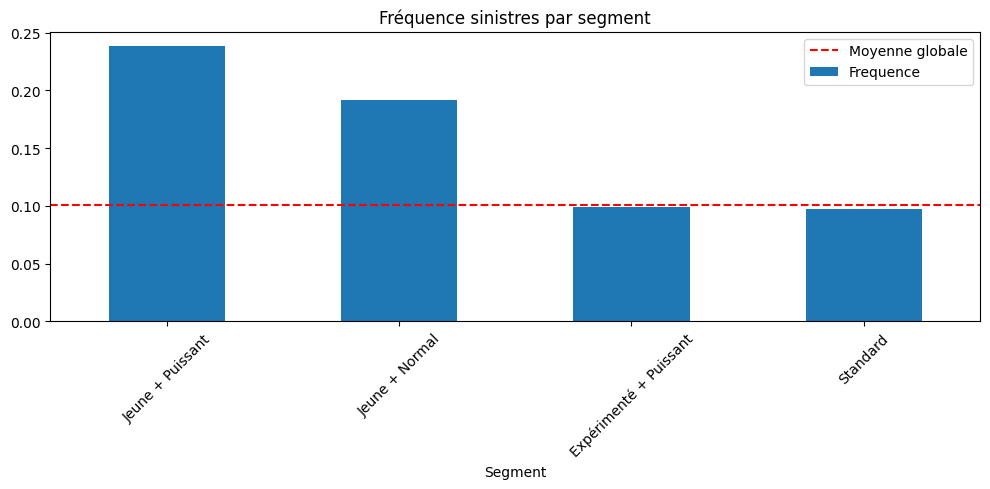

In [73]:
conditions = [
    (df_train_freq['DrivAge'] < 25) & (df_train_freq['VehPower'] > 10),
    (df_train_freq['DrivAge'] < 25),
    (df_train_freq['VehPower'] > 10)
]
choix = ['Jeune + Puissant', 'Jeune + Normal', 'Expérimenté + Puissant']
df_train_freq['Segment'] = np.select(conditions, choix, default='Standard')

freq_globale = df_train_freq['ClaimNb'].sum() / df_train_freq['Exposure'].sum()

analysis = df_train_freq.groupby('Segment').agg({
    'IDpol': 'count',
    'ClaimNb': 'sum',
    'Exposure': 'sum'
}).rename(columns={'IDpol': 'Nb_contrats'})

analysis['Frequence'] = analysis['ClaimNb'] / analysis['Exposure']
analysis['Ratio_vs_Moy'] = analysis['Frequence'] / freq_globale

analysis = analysis.sort_values('Frequence', ascending=False)
print(analysis[['Nb_contrats', 'Frequence', 'Ratio_vs_Moy']])

analysis['Frequence'].plot(kind='bar', figsize=(10, 5), title='Fréquence sinistres par segment', rot=45)
plt.axhline(freq_globale, color='r', linestyle='--', label='Moyenne globale')
plt.legend()
plt.tight_layout()
plt.show()

 DENSITY PAR AREA:
              mean   median          std
Area                                    
F     22006.432498  27000.0  6383.028363
E      4382.666594   3744.0  1954.282327
D      1075.309507   1054.0   398.573182
C       248.814099    222.0   113.780412
B        72.581159     72.0    14.828016
A        27.505080     27.0    12.472811


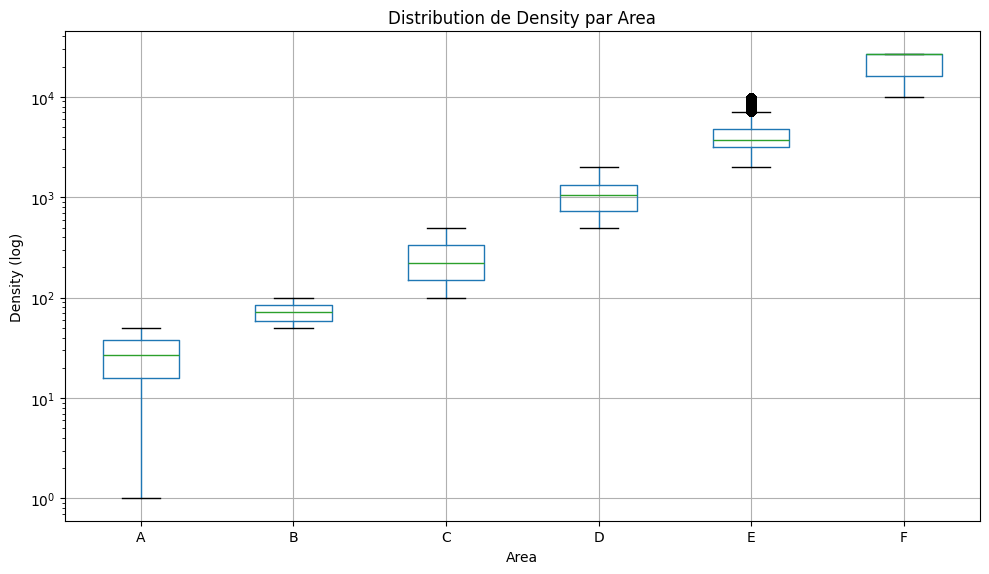

In [74]:
area_density = df_train_freq.groupby('Area')['Density'].agg(['mean', 'median', 'std'])
print(" DENSITY PAR AREA:")
print(area_density.sort_values('mean', ascending=False))

fig, ax = plt.subplots(figsize=(10, 6))
df_train_freq.boxplot(column='Density', by='Area', ax=ax)
ax.set_title('Distribution de Density par Area')
ax.set_xlabel('Area')
ax.set_ylabel('Density (log)')
ax.set_yscale('log')
plt.suptitle('') 
plt.tight_layout()
plt.show()

On voit ici très clairement que Area est un découpage de Density en 6 catégories, comme Density possède plus d'informations, nous supprimerons donc la variable (`Area`).

## 6. Preprocessing

In [75]:
X_train_freq = df_train.drop(columns=['IDpol', 'ClaimNb', 'ClaimAmount', 'Severity', 'Exposure', 'Frequency', 'Area'])
y_train_freq = df_train['ClaimNb']
expo_train = df_train['Exposure'].values

X_test_freq = df_test.drop(columns=['IDpol', 'ClaimNb', 'ClaimAmount', 'Severity', 'Exposure'])
y_test_freq = df_test['ClaimNb']
expo_test = df_test['Exposure'].values

print(f"\n FRÉQUENCE (tous les contrats):")
print(f"   X_train: {X_train_freq.shape}")
print(f"   X_test:  {X_test_freq.shape}")


 FRÉQUENCE (tous les contrats):
   X_train: (541353, 8)
   X_test:  (135339, 10)


In [76]:
seuil_capping = df_train.loc[df_train['ClaimAmount'] > 0, 'ClaimAmount'].quantile(0.99)

print(f"Vrai seuil (99% des sinistres) : {seuil_capping:,.0f} €")

y_train_capped = df_train['ClaimAmount'].clip(upper=seuil_capping)
y_test_capped = df_test['ClaimAmount'].clip(upper=seuil_capping) 

total_reel = df_train['ClaimAmount'].sum()
total_capped = y_train_capped.sum()
perte_ecrêtement = total_reel - total_capped

chargement_moyen = perte_ecrêtement / len(df_train)

print(f"Montant total écrêté : {perte_ecrêtement:,.0f}€")
print(f"--> Surcharge à ajouter au tarif final : +{chargement_moyen:.2f}€ par contrat")

Vrai seuil (99% des sinistres) : 18,211 €
Montant total écrêté : 8,614,687€
--> Surcharge à ajouter au tarif final : +15.91€ par contrat


In [77]:
train_sev_mask = (df_train['ClaimNb'] > 0) & (df_train['Severity'] > 0)
test_sev_mask = (df_test['ClaimNb'] > 0) & (df_test['Severity'] > 0)

X_train_sev = df_train_sev[train_sev_mask].drop(columns=['IDpol', 'ClaimNb', 'ClaimAmount', 'Exposure', 'Area', 'Severity','VehBrand']).reset_index(drop=True)
X_test_sev = df_test[test_sev_mask].drop(columns=['IDpol', 'ClaimNb', 'ClaimAmount', 'Severity', 'Exposure','VehBrand']).reset_index(drop=True)

y_train_sev = y_train_capped[train_sev_mask].reset_index(drop=True)
y_test_sev = y_test_capped[test_sev_mask].reset_index(drop=True)

weight_train_sev = df_train[train_sev_mask]['ClaimNb'].values
weight_test_sev = df_test[test_sev_mask]['ClaimNb'].values

print(f"Shape X_train_sev: {X_train_sev.shape}")
print(f"Shape y_train_sev: {y_train_sev.shape}")
print(f"Distribution y_train_sev (log): min={y_train_sev.min():.2f}, max={y_train_sev.max():.2f}, mean={y_train_sev.mean():.2f}")

Shape X_train_sev: (19882, 8)
Shape y_train_sev: (19882,)
Distribution y_train_sev (log): min=1.00, max=18210.97, mean=1665.24


C:\Users\lucas\AppData\Local\Temp\ipykernel_18140\842148568.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_sev = df_train_sev[train_sev_mask].drop(columns=['IDpol', 'ClaimNb', 'ClaimAmount', 'Exposure', 'Area', 'Severity','VehBrand']).reset_index(drop=True)


In [78]:
X_train_freq.info()
X_train_sev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541353 entries, 500153 to 90368
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   VehPower    541353 non-null  int64 
 1   VehAge      541353 non-null  int64 
 2   DrivAge     541353 non-null  int64 
 3   BonusMalus  541353 non-null  int64 
 4   VehBrand    541353 non-null  object
 5   VehGas      541353 non-null  object
 6   Density     541353 non-null  int64 
 7   Region      541353 non-null  object
dtypes: int64(5), object(3)
memory usage: 53.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19882 entries, 0 to 19881
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   VehPower    19882 non-null  int64  
 1   VehAge      19882 non-null  int64  
 2   DrivAge     19882 non-null  int64  
 3   BonusMalus  19882 non-null  int64  
 4   VehGas      19882 non-null  object 
 5   Density     19882 non-null  in

A travers l'EDA, on a observé la présence de contrats avec des fréquences de sinistres aberrantes, supprimons-les

Par ailleurs, les montants de sinistres suivent typiquement une distribution log-normale ou gamma, pas une distribution normale. La transformation log permet de se rapprocher d'une distribution normale.

### Encodage

Pour préparer les variables catégorielles ne présentant aucun ordre entre leurs modalités, nous allons utiliser le one-hot encoder

In [79]:
feature_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 
                'VehBrand', 'VehGas', 'Density', 'Region']

num_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
cat_cols = ['VehGas', 'Region']

In [80]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, ['VehGas','Region'])
    ],
    remainder='drop'
)


#Fréquence
X_train_freq_final = preprocessor.fit_transform(X_train_freq)
X_test_freq_final = preprocessor.transform(X_test_freq)

print(f"\n Fréquence - Preprocessing appliqué :")
print(f"   X_train : {X_train_freq.shape} → {X_train_freq_final.shape}")
print(f"   X_test  : {X_test_freq.shape} → {X_test_freq_final.shape}")

# Sévérité
X_train_sev_final = preprocessor.fit_transform(X_train_sev)
X_test_sev_final = preprocessor.transform(X_test_sev)

print(f"\n Sévérité - Preprocessing appliqué :")
print(f"   X_train : {X_train_sev.shape} → {X_train_sev_final.shape}")
print(f"   X_test  : {X_test_sev.shape} → {X_test_sev_final.shape}")


 Fréquence - Preprocessing appliqué :
   X_train : (541353, 8) → (541353, 27)
   X_test  : (135339, 10) → (135339, 27)

 Sévérité - Preprocessing appliqué :
   X_train : (19882, 8) → (19882, 27)
   X_test  : (5006, 9) → (5006, 27)


## 6. Validation croisée

In [81]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)

Pour représenter l'efficacité de nos résultats, on va s'appuyer sur différentes métriques, définissons-les.

In [82]:
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, mean_poisson_deviance, mean_gamma_deviance, d2_tweedie_score

def safe_poisson_deviance(y_true, y_pred):
    y_pred_safe = np.maximum(y_pred, 1e-10) 
    return mean_poisson_deviance(y_true, y_pred_safe)

def safe_gamma_deviance(y_true, y_pred):
    y_pred_safe = np.maximum(y_pred, 1e-10)
    return mean_gamma_deviance(y_true, y_pred_safe)


scoring_freq = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'Poisson_Dev': make_scorer(safe_poisson_deviance, greater_is_better=False),
    'D2_Poisson': make_scorer(d2_tweedie_score, power=1) 
}

scoring_sev = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'Gamma_Dev': make_scorer(safe_gamma_deviance, greater_is_better=False),
    'D2_Gamma': make_scorer(d2_tweedie_score, power=2) 
}

In [83]:
print(f"\n" + "="*80)
print("GRIDSEARCHCV - FRÉQUENCE (XGBoost Poisson)")
print("="*80)

param_grid_xgb_freq = {
    'n_estimators': [100, 200],
    'max_depth': [7, 9],
    'learning_rate': [0.2, 0.3],
}

xgb_freq = xgb.XGBRegressor(
    objective='count:poisson',
    tree_method='hist', 
    device='cuda',
    random_state=42,
    n_jobs=1,               
)


grid_freq_xgb = GridSearchCV(
    estimator=xgb_freq,
    param_grid=param_grid_xgb_freq,
    cv=kf,
    scoring=scoring_freq,
    refit='D2_Poisson', 
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print(f"\n Lancement GridSearchCV pour FRÉQUENCE (XGBoost)...")
print(f"   Combinaisons : {8}")
print(f"   Total fits   : {8 * 5}")
print(f"   Durée estimée : ~{8 * 5 * 1 / 60:.0f} minutes")
print("\n" + "─"*80)

start_time = time.time()

#  LANCER LA RECHERCHE SUR TRAIN
grid_freq_xgb.fit(X_train_freq_final, y_train_freq)

elapsed_freq_xgb = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV GLM Poisson terminé en {elapsed_freq_xgb:.1f}s")


GRIDSEARCHCV - FRÉQUENCE (XGBoost Poisson)

 Lancement GridSearchCV pour FRÉQUENCE (XGBoost)...
   Combinaisons : 8
   Total fits   : 40
   Durée estimée : ~1 minutes

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 8 candidates, totalling 40 fits
────────────────────────────────────────────────────────────────────────────────

 GridSearchCV GLM Poisson terminé en 38.6s


In [84]:
print(f"\n MEILLEURS HYPERPARAMÈTRES (Fréquence XGBoost) :")
print("─"*80)
for param, value in grid_freq_xgb.best_params_.items():
    print(f"   {param:20} : {value}")

print(f"\n PERFORMANCES SUR TRAIN (CV) :")
print("─"*80)
best_index = grid_freq_xgb.best_index_
cv_results = grid_freq_xgb.cv_results_

for metric in ['MSE', 'MAE', 'Poisson_Dev', 'R2']:
    mean_key = f'mean_test_{metric}'
    std_key = f'std_test_{metric}'
    
    if mean_key in cv_results:
        mean_val = cv_results[mean_key][best_index]
        std_val = cv_results[std_key][best_index]
        
        if metric != 'R2':
            mean_val = -mean_val
        
        print(f"   {metric:15} : {mean_val:.6f} ± {std_val:.6f}")

train_mse_freq = -cv_results['mean_train_MSE'][best_index]
test_mse_freq = -cv_results['mean_test_MSE'][best_index]
ratio_freq = test_mse_freq / train_mse_freq

print(f"\n🔍 Analyse overfitting :")
print(f"   Train MSE : {train_mse_freq:.6f}")
print(f"   Test MSE  : {test_mse_freq:.6f}")
print(f"   Ratio     : {ratio_freq:.3f}")



 MEILLEURS HYPERPARAMÈTRES (Fréquence XGBoost) :
────────────────────────────────────────────────────────────────────────────────
   learning_rate        : 0.2
   max_depth            : 9
   n_estimators         : 100

 PERFORMANCES SUR TRAIN (CV) :
────────────────────────────────────────────────────────────────────────────────
   MSE             : 0.055959 ± 0.001987
   MAE             : 0.097888 ± 0.000897
   Poisson_Dev     : 0.302470 ± 0.004877

🔍 Analyse overfitting :
   Train MSE : 0.051856
   Test MSE  : 0.055959
   Ratio     : 1.079


In [85]:
print(f"\n" + "="*80)
print("MODÈLE 3/5 : GLM POISSON (sklearn)")
print("="*80)


param_grid_glm = {
    'alpha': [0.0, 0.1, 1.0],    
    'max_iter': [300]
}

n_comb_glm = 3


model_glm_poisson = PoissonRegressor(max_iter=300)


grid_freq_glm = GridSearchCV(
    estimator=model_glm_poisson,
    param_grid=param_grid_glm,
    cv=kf,
    scoring=scoring_freq,
    refit='D2_Poisson',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)


print(f"\n Lancement GridSearchCV GLM Poisson...")
print(f"   Combinaisons : {n_comb_glm}")
print(f"   Total fits   : {n_comb_glm * 5}")
print("\n" + "─"*80)

start_time = time.time()
grid_freq_glm.fit(X_train_freq_final, y_train_freq)
elapsed_freq_glm = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV GLM Poisson terminé en {elapsed_freq_glm:.1f}s")

print(f"\n MEILLEURS HYPERPARAMÈTRES (GLM Poisson) :")
print("─"*80)
for param, value in grid_freq_glm.best_params_.items():
    print(f"   {param:20} : {value}")

# Performances
best_index = grid_freq_glm.best_index_
cv_results = grid_freq_glm.cv_results_

print(f"\n📊 Performances (CV) :")
for metric in ['MSE', 'MAE', 'Poisson_Dev', 'R2']:
    mean_key = f'mean_test_{metric}'
    if mean_key in cv_results:
        mean_val = cv_results[mean_key][best_index]
        std_val = cv_results[f'std_test_{metric}'][best_index]
        if metric != 'R2':
            mean_val = -mean_val
        print(f"   {metric:15} : {mean_val:.6f} ± {std_val:.6f}")


MODÈLE 3/5 : GLM POISSON (sklearn)

 Lancement GridSearchCV GLM Poisson...
   Combinaisons : 3
   Total fits   : 15

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 3 candidates, totalling 15 fits
────────────────────────────────────────────────────────────────────────────────

 GridSearchCV GLM Poisson terminé en 4.5s

 MEILLEURS HYPERPARAMÈTRES (GLM Poisson) :
────────────────────────────────────────────────────────────────────────────────
   alpha                : 0.0
   max_iter             : 300

📊 Performances (CV) :
   MSE             : 0.056978 ± 0.002158
   MAE             : 0.100478 ± 0.000903
   Poisson_Dev     : 0.314935 ± 0.005334


In [86]:
print(f"\n" + "="*80)
print("GRIDSEARCHCV - FRÉQUENCE (LightGBM Poisson)")
print("="*80)

param_grid_lgb_freq = {
    'n_estimators': [200, 400],
    'max_depth': [5, -1],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 63],
    'min_child_samples': [20],
}

n_comb_lgb = 16

# Modèle de base
lgb_freq = lgb.LGBMRegressor(
    objective='poisson',
    device='gpu',          
    gpu_platform_id=0,
    gpu_device_id=0,
    n_jobs=1,         
    random_state=42
)

# GridSearchCV
grid_freq_lgb = GridSearchCV(
    estimator=lgb_freq,
    param_grid=param_grid_lgb_freq,
    cv=kf,
    scoring=scoring_freq,
    refit='D2_Poisson',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print(f"\n Lancement GridSearchCV pour FRÉQUENCE (LightGBM)...")
print(f"   Combinaisons : {n_comb_lgb}")
print("\n" + "─"*80)

start_time = time.time()
grid_freq_lgb.fit(X_train_freq_final, y_train_freq)
elapsed_freq_lgb = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV FRÉQUENCE (LightGBM) terminé en {elapsed_freq_lgb:.1f}s")

print(f"\n MEILLEURS HYPERPARAMÈTRES (Fréquence LightGBM) :")
print("─"*80)
for param, value in grid_freq_lgb.best_params_.items():
    print(f"   {param:20} : {value}")

# Performances CV
best_index = grid_freq_lgb.best_index_
cv_results = grid_freq_lgb.cv_results_

print(f"\n Performances (CV) :")
print("─"*80)
for metric in ['MSE', 'MAE', 'Poisson_Dev', 'R2']:
    mean_key = f'mean_test_{metric}'
    if mean_key in cv_results:
        mean_val = cv_results[mean_key][best_index]
        std_val = cv_results[f'std_test_{metric}'][best_index]
        if metric != 'R2':
            mean_val = -mean_val
        print(f"   {metric:15} : {mean_val:.6f} ± {std_val:.6f}")

# Stocker les résultats
lgb_freq_result = {
    'Modèle': 'LightGBM Poisson',
    'Grid': grid_freq_lgb,
    'Elapsed': elapsed_freq_lgb,
    'Poisson_Dev': -cv_results['mean_test_Poisson_Dev'][best_index]  # ← Important !
}

print("\n✓ Résultats stockés dans lgb_freq_result")


GRIDSEARCHCV - FRÉQUENCE (LightGBM Poisson)

 Lancement GridSearchCV pour FRÉQUENCE (LightGBM)...
   Combinaisons : 16

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 541353, number of used features: 27
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (4.13 MB) transferred to GPU in 0.006487 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -2.933071
────────────────────────────────────────────────────────────────────────────────

 GridSearchCV 

In [87]:
print(f"\n" + "="*80)
print("MODÈLE 5/5 : RANDOM FOREST")
print("="*80)



# Grille Random Forest 
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [20],
    'min_samples_split': [5],
}

n_comb_rf = 2 * 2 * 2  

# Modèle
model_rf_freq = RandomForestRegressor(
    random_state=42,
    n_jobs=-1, 
    verbose=0
)

# GridSearchCV
grid_freq_rf = GridSearchCV(
    estimator=model_rf_freq,
    param_grid=param_grid_rf,
    cv=kf,
    scoring=scoring_freq,
    refit='D2_Poisson',
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

print(f"\n⏳ Lancement GridSearchCV Random Forest...")
print(f"   Combinaisons : {n_comb_rf}")
print(f"   Total fits   : {n_comb_rf * 5}")
print(f"   ⚠️  Random Forest est sur CPU (peut être lent)")
print("\n" + "─"*80)

start_time = time.time()
grid_freq_rf.fit(X_train_freq_final, y_train_freq)
elapsed_freq_rf = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV Random Forest terminé en {elapsed_freq_rf:.1f}s ({elapsed_freq_rf/60:.1f} min)")

print(f"\n MEILLEURS HYPERPARAMÈTRES (Random Forest) :")
print("─"*80)
for param, value in grid_freq_rf.best_params_.items():
    print(f"   {param:20} : {value}")

# Performances
best_index = grid_freq_rf.best_index_
cv_results = grid_freq_rf.cv_results_

print(f"\n Performances (CV) :")
for metric in ['MSE', 'MAE', 'Poisson_Dev', 'R2']:
    mean_key = f'mean_test_{metric}'
    if mean_key in cv_results:
        mean_val = cv_results[mean_key][best_index]
        std_val = cv_results[f'std_test_{metric}'][best_index]
        if metric != 'R2':
            mean_val = -mean_val
        print(f"   {metric:15} : {mean_val:.6f} ± {std_val:.6f}")


MODÈLE 5/5 : RANDOM FOREST

⏳ Lancement GridSearchCV Random Forest...
   Combinaisons : 8
   Total fits   : 40
   ⚠️  Random Forest est sur CPU (peut être lent)

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lucas\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_regression.py", line 1671, in d2_tweedie_score
    numerator = mean_tweedie_deviance(
                ^^^^^^^^^^^^^^^^^^^^^^
  Fil

[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  24.1s


C:\Users\lucas\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_regression.py", line 1671, in d2_tweedie_score
    numerator = mean_tweedie_deviance(
                ^^^^^^^^^^^^^^^^^^^^^^
  Fil

[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  23.8s


C:\Users\lucas\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_regression.py", line 1671, in d2_tweedie_score
    numerator = mean_tweedie_deviance(
                ^^^^^^^^^^^^^^^^^^^^^^
  Fil

[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  23.9s


C:\Users\lucas\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_regression.py", line 1671, in d2_tweedie_score
    numerator = mean_tweedie_deviance(
                ^^^^^^^^^^^^^^^^^^^^^^
  Fil

[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  24.2s


C:\Users\lucas\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucas\.venv\Lib\site-packages\sklearn\metrics\_regression.py", line 1671, in d2_tweedie_score
    numerator = mean_tweedie_deviance(
                ^^^^^^^^^^^^^^^^^^^^^^
  Fil

[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  24.0s
────────────────────────────────────────────────────────────────────────────────

 GridSearchCV Random Forest terminé en 156.2s (2.6 min)

 MEILLEURS HYPERPARAMÈTRES (Random Forest) :
────────────────────────────────────────────────────────────────────────────────
   max_depth            : 20
   min_samples_split    : 5
   n_estimators         : 100

 Performances (CV) :
   MSE             : 0.056455 ± 0.001869
   MAE             : 0.098959 ± 0.000922
   Poisson_Dev     : 0.311093 ± 0.005359


In [88]:
print(f"\n" + "="*80)
print("CRÉATION DU TABLEAU DE COMPARAISON")
print("="*80)

# Liste pour stocker les résultats
results_freq = []

# Ajouter chaque modèle (adaptez selon vos modèles)
# Exemple pour GLM
results_freq.append({
    'Modèle': 'GLM Poisson',
    'MSE (CV)': -grid_freq_glm.cv_results_['mean_test_MSE'][grid_freq_glm.best_index_],
    'MAE (CV)': -grid_freq_glm.cv_results_['mean_test_MAE'][grid_freq_glm.best_index_],
    'Poisson Dev (CV)': -grid_freq_glm.cv_results_['mean_test_Poisson_Dev'][grid_freq_glm.best_index_],
    'Temps (min)': elapsed_freq_glm / 60
})

# Exemple pour XGBoost
results_freq.append({
    'Modèle': 'XGBoost',
    'MSE (CV)': -grid_freq_xgb.cv_results_['mean_test_MSE'][grid_freq_xgb.best_index_],
    'MAE (CV)': -grid_freq_xgb.cv_results_['mean_test_MAE'][grid_freq_xgb.best_index_],
    'Poisson Dev (CV)': -grid_freq_xgb.cv_results_['mean_test_Poisson_Dev'][grid_freq_xgb.best_index_],
    'Temps (min)': elapsed_freq_xgb / 60
})

# Exemple pour LightGBM
results_freq.append({
    'Modèle': 'LightGBM',
    'MSE (CV)': -grid_freq_lgb.cv_results_['mean_test_MSE'][grid_freq_lgb.best_index_],
    'MAE (CV)': -grid_freq_lgb.cv_results_['mean_test_MAE'][grid_freq_lgb.best_index_],
    'Poisson Dev (CV)': -grid_freq_lgb.cv_results_['mean_test_Poisson_Dev'][grid_freq_lgb.best_index_],
    'Temps (min)': elapsed_freq_lgb / 60
})

# Exemple pour Random Forest
results_freq.append({
    'Modèle': 'Random Forest',
    'MSE (CV)': -grid_freq_rf.cv_results_['mean_test_MSE'][grid_freq_rf.best_index_],
    'MAE (CV)': -grid_freq_rf.cv_results_['mean_test_MAE'][grid_freq_rf.best_index_],
    'Poisson Dev (CV)': -grid_freq_rf.cv_results_['mean_test_Poisson_Dev'][grid_freq_rf.best_index_],
    'Temps (min)': elapsed_freq_rf / 60
})

# Créer le DataFrame et trier par MSE
comparison_freq = pd.DataFrame(results_freq)
comparison_freq = comparison_freq.sort_values('MSE (CV)').reset_index(drop=True)

# Afficher le tableau
print("\n TABLEAU DE COMPARAISON DES MODÈLES (FRÉQUENCE)")
print("="*80)
print(comparison_freq.to_string(index=False))
print("="*80)


CRÉATION DU TABLEAU DE COMPARAISON

 TABLEAU DE COMPARAISON DES MODÈLES (FRÉQUENCE)
       Modèle  MSE (CV)  MAE (CV)  Poisson Dev (CV)  Temps (min)
     LightGBM  0.055864  0.098620          0.302112     2.923344
      XGBoost  0.055959  0.097888          0.302470     0.642983
Random Forest  0.056455  0.098959          0.311093     2.604129
  GLM Poisson  0.056978  0.100478          0.314935     0.074954



GÉNÉRATION DES VISUALISATIONS


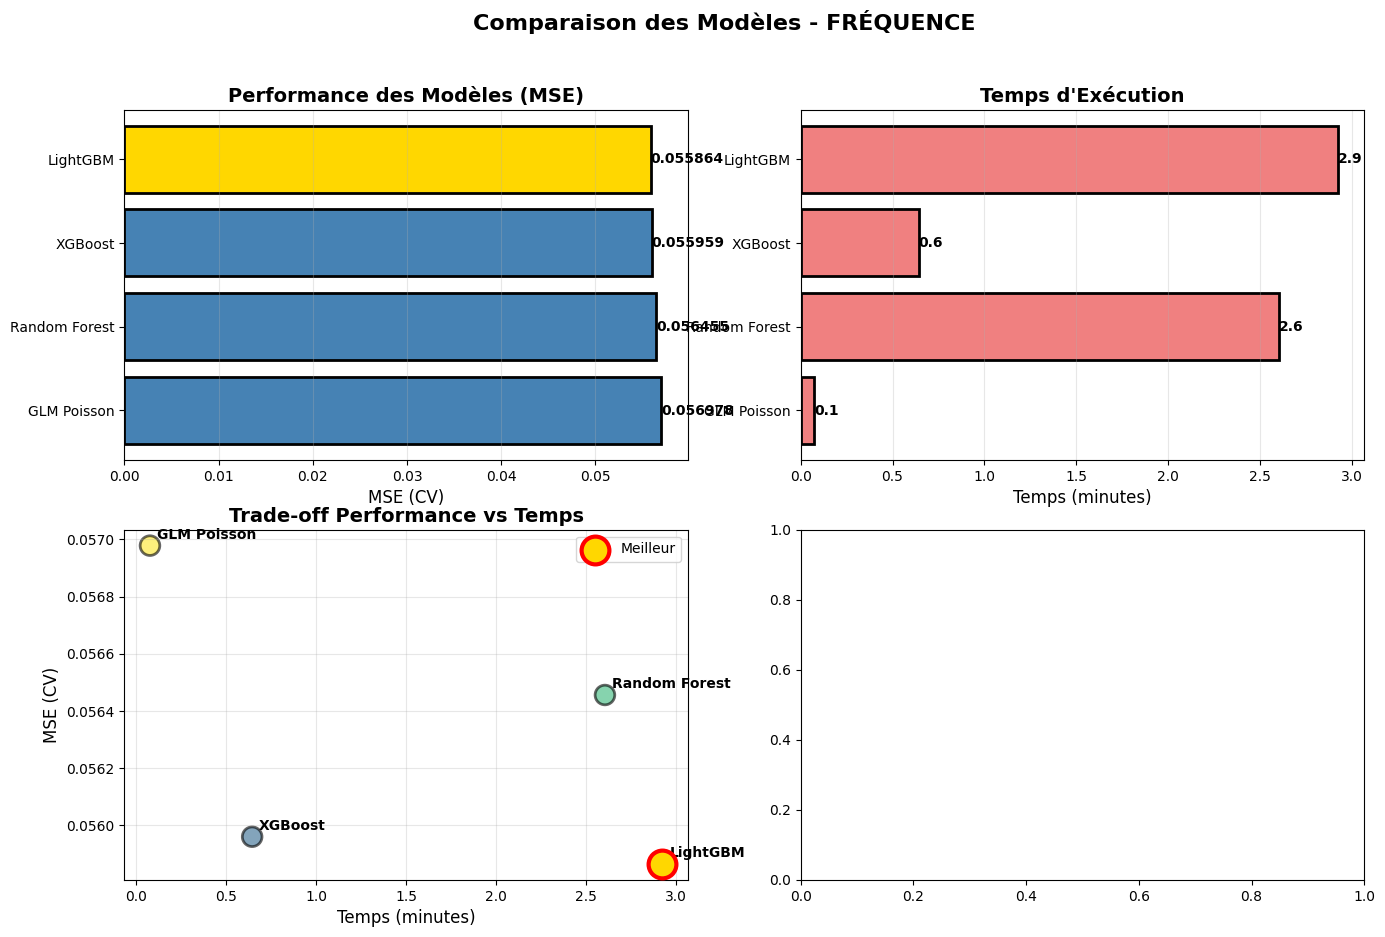

In [89]:
print(f"\n" + "="*80)
print("GÉNÉRATION DES VISUALISATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Comparaison des Modèles - FRÉQUENCE', fontsize=16, fontweight='bold')

# Plot 1 : MSE par modèle
ax1 = axes[0, 0]
models = comparison_freq['Modèle'].values
mse_values = comparison_freq['MSE (CV)'].values
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(models))]

bars = ax1.barh(models, mse_values, color=colors, edgecolor='black', linewidth=2)
ax1.set_xlabel('MSE (CV)', fontsize=12)
ax1.set_title('Performance des Modèles (MSE)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Ajouter valeurs
for bar, val in zip(bars, mse_values):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2.,
            f'{val:.6f}', ha='left', va='center', fontweight='bold')

# Plot 2 : Temps d'exécution
ax2 = axes[0, 1]
times = comparison_freq['Temps (min)'].values
bars2 = ax2.barh(models, times, color='lightcoral', edgecolor='black', linewidth=2)
ax2.set_xlabel('Temps (minutes)', fontsize=12)
ax2.set_title('Temps d\'Exécution', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Ajouter valeurs
for bar, val in zip(bars2, times):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
            f'{val:.1f}', ha='left', va='center', fontweight='bold')

# Plot 3 : Trade-off Performance vs Temps
ax3 = axes[1, 0]
ax3.scatter(comparison_freq['Temps (min)'], comparison_freq['MSE (CV)'], 
           s=200, alpha=0.6, c=range(len(comparison_freq)), cmap='viridis',
           edgecolor='black', linewidth=2)

for idx, row in comparison_freq.iterrows():
    ax3.annotate(row['Modèle'], 
                (row['Temps (min)'], row['MSE (CV)']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

ax3.set_xlabel('Temps (minutes)', fontsize=12)
ax3.set_ylabel('MSE (CV)', fontsize=12)
ax3.set_title('Trade-off Performance vs Temps', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

# Marquer le champion
best_time = comparison_freq.iloc[0]['Temps (min)']
best_mse = comparison_freq.iloc[0]['MSE (CV)']
ax3.scatter([best_time], [best_mse], s=400, 
           color='gold', edgecolor='red', linewidth=3, zorder=5,
           label='Meilleur')
ax3.legend()


### 6.2 Comparaison modèle sévérité

In [90]:
print(f"\n" + "="*80)
print("GRIDSEARCHCV - SÉVÉRITÉ (XGBoost Gamma)")
print("="*80)


param_grid_xgb_sev = {
    'max_depth': [3, 4, 5],
    'n_estimators': [300,400,500],
    'learning_rate': [0.01],
    'min_child_weight': [15,20,25],
    'colsample_bytree': [0.5,0.6,0.7]
}

grid_sev_xgb = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:gamma',
        eval_metric='gamma-nloglik',
        tree_method='hist',
        random_state=42,
        verbosity=0
    ),
    param_grid=param_grid_xgb_sev,
    cv=kf,
    scoring=scoring_sev,     
    refit='D2_Gamma',      
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print(f"\n Lancement GridSearchCV pour SÉVÉRITÉ (XGBoost)...")
print("\n" + "─"*80)

start_time = time.time()
grid_sev_xgb.fit(X_train_sev_final, y_train_sev)
elapsed_sev_xgb = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV SÉVÉRITÉ terminé en {elapsed_sev_xgb:.1f}s")

print(f"\n MEILLEURS HYPERPARAMÈTRES (Sévérité XGBoost) :")
print("─"*80)
for param, value in grid_sev_xgb.best_params_.items():
    print(f"   {param:20} : {value}")

print(f"\n RÉSULTATS RÉELS (Validation Croisée) :")
print("─"*80)

d2_score = grid_sev_xgb.best_score_
print(f"   D2 Gamma (Score) : {d2_score:.4%} ")


best_index = grid_sev_xgb.best_index_
mae_score = -grid_sev_xgb.cv_results_['mean_test_MAE'][best_index]
print(f"   MAE (Erreur Moy) : {mae_score:,.2f}€")


GRIDSEARCHCV - SÉVÉRITÉ (XGBoost Gamma)

 Lancement GridSearchCV pour SÉVÉRITÉ (XGBoost)...

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 81 candidates, totalling 405 fits
────────────────────────────────────────────────────────────────────────────────

 GridSearchCV SÉVÉRITÉ terminé en 21.8s

 MEILLEURS HYPERPARAMÈTRES (Sévérité XGBoost) :
────────────────────────────────────────────────────────────────────────────────
   colsample_bytree     : 0.6
   learning_rate        : 0.01
   max_depth            : 3
   min_child_weight     : 25
   n_estimators         : 500

 RÉSULTATS RÉELS (Validation Croisée) :
────────────────────────────────────────────────────────────────────────────────
   D2 Gamma (Score) : 1.0055% 
   MAE (Erreur Moy) : 1,186.92€


In [91]:
print(f"\n" + "="*80)
print("GRIDSEARCHCV - SÉVÉRITÉ (LightGBM Gamma)")
print("="*80)

param_grid_lgb_sev = {
    'learning_rate': [0.01, 0.05, 0.1], 
    'n_estimators': [300,400,500],
    'max_depth': [3, 5],             
    'num_leaves': [15, 31],             
    'min_child_samples': [20, 50],
    'reg_alpha': [0.1],              
    'reg_lambda': [0]
}

lgb_sev = lgb.LGBMRegressor(
    objective='gamma',
    random_state=42,
    verbosity=-1,
    n_jobs=-1,    
    device='gpu',   
    gpu_platform_id=0,
    gpu_device_id=0,
    max_bin=63     
)

grid_sev_lgb = GridSearchCV(
    estimator=lgb_sev,
    param_grid=param_grid_lgb_sev,
    cv=kf,
    scoring=scoring_sev,
    refit='D2_Gamma',    
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print(f"\n⏳ Lancement GridSearchCV pour SÉVÉRITÉ (LightGBM)...")
print("\n" + "─"*80)

start_time = time.time()

grid_sev_lgb.fit(X_train_sev_final, y_train_sev)

elapsed_sev_lgb = time.time() - start_time

print("─"*80)
print(f"GridSearchCV SÉVÉRITÉ (LightGBM) terminé en {elapsed_sev_lgb:.1f}s")

print(f"\n MEILLEURS HYPERPARAMÈTRES :")
print("─"*80)
for param, value in grid_sev_lgb.best_params_.items():
    print(f"   {param:20} : {value}")

print(f"\n RÉSULTATS RÉELS (Validation Croisée) :")
print("─"*80)


d2_score = grid_sev_lgb.best_score_
print(f"   D2 Gamma (Score)     : {d2_score:.4%}")

best_idx = grid_sev_lgb.best_index_
mae_score = -grid_sev_lgb.cv_results_['mean_test_MAE'][best_idx]

print(f"   MAE (Erreur Moyenne) : {mae_score:,.2f}€")


lgb_sev_result = {
    'Modèle': 'LightGBM Gamma',
    'Grid': grid_sev_lgb,
    'Elapsed': elapsed_sev_lgb,
    'Best_D2': d2_score,
    'Best_MAE': mae_score 
}


GRIDSEARCHCV - SÉVÉRITÉ (LightGBM Gamma)

⏳ Lancement GridSearchCV pour SÉVÉRITÉ (LightGBM)...

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 72 candidates, totalling 360 fits
────────────────────────────────────────────────────────────────────────────────
GridSearchCV SÉVÉRITÉ (LightGBM) terminé en 256.6s

 MEILLEURS HYPERPARAMÈTRES :
────────────────────────────────────────────────────────────────────────────────
   learning_rate        : 0.01
   max_depth            : 3
   min_child_samples    : 20
   n_estimators         : 500
   num_leaves           : 15
   reg_alpha            : 0.1
   reg_lambda           : 0

 RÉSULTATS RÉELS (Validation Croisée) :
────────────────────────────────────────────────────────────────────────────────
   D2 Gamma (Score)     : 0.9463%
   MAE (Erreur Moyenne) : 1,187.35€


In [95]:
# ============================================================================
# MODÈLE : GLM GAMMA (Sévérité)
# ============================================================================

print(f"\n" + "="*80)
print("MODÈLE : GLM GAMMA (Sévérité)")
print("="*80)

param_grid_glm_sev = {
    'alpha': [0, 0.008, 0.01, 0.012, 0.015, 0.02, 0.05], 
    'solver': ['lbfgs'], 
    'tol': [1e-4, 1e-6, 1e-7],
    'max_iter': [10,20,50,100]
}
n_comb_glm_sev = 32

model_glm_gamma = GammaRegressor(max_iter=300)

grid_sev_glm = GridSearchCV(
    estimator=model_glm_gamma,
    param_grid=param_grid_glm_sev,
    cv=kf,
    scoring=scoring_sev,
    refit='MSE',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print(f"\n⏳ Lancement GridSearchCV GLM Gamma...")
print(f"   Combinaisons : {n_comb_glm_sev}")
print(f"   Total fits   : {n_comb_glm_sev * 5}")
print("\n" + "─"*80)

start_time = time.time()
grid_sev_glm.fit(X_train_sev_final, y_train_sev)
elapsed_sev_glm = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV GLM Gamma terminé en {elapsed_sev_glm:.1f}s")

print(f"\n MEILLEURS HYPERPARAMÈTRES (GLM Gamma) :")
print("─"*80)
for param, value in grid_sev_glm.best_params_.items():
    print(f"   {param:20} : {value}")

# Performances
best_index = grid_sev_glm.best_index_
cv_results = grid_sev_glm.cv_results_

print(f"\n Performances (CV) :")
print("─"*80)
for metric in ['MSE', 'MAE', 'Gamma_Dev', 'R2']:
    mean_key = f'mean_test_{metric}'
    if mean_key in cv_results:
        mean_val = cv_results[mean_key][best_index]
        std_val = cv_results[f'std_test_{metric}'][best_index]
        if metric != 'R2':
            mean_val = -mean_val
        print(f"   {metric:15} : {mean_val:.6f}")


train_mse = -cv_results['mean_train_MSE'][best_index]
test_mse = -cv_results['mean_test_MSE'][best_index]
ratio = test_mse / train_mse

print(f"\n Analyse overfitting :")
print(f"   Train MSE : {train_mse:.2f}")
print(f"   Test MSE  : {test_mse:.2f}")
print(f"   Ratio     : {ratio:.3f}")


# Stocker les résultats
glm_sev_result = {
    'Modèle': 'GLM Gamma',
    'Grid': grid_sev_glm,
    'Elapsed': elapsed_sev_glm
}


MODÈLE : GLM GAMMA (Sévérité)

⏳ Lancement GridSearchCV GLM Gamma...
   Combinaisons : 32
   Total fits   : 160

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 84 candidates, totalling 420 fits
────────────────────────────────────────────────────────────────────────────────

 GridSearchCV GLM Gamma terminé en 3.4s

 MEILLEURS HYPERPARAMÈTRES (GLM Gamma) :
────────────────────────────────────────────────────────────────────────────────
   alpha                : 0.02
   max_iter             : 50
   solver               : lbfgs
   tol                  : 1e-07

 Performances (CV) :
────────────────────────────────────────────────────────────────────────────────
   MSE             : 5913173.776445
   MAE             : 1197.322538
   Gamma_Dev       : 1.062391

 Analyse overfitting :
   Train MSE : 5900072.78
   Test MSE  : 5913173.78
   Ratio     : 1.002


In [93]:
models_to_compare = [
    glm_sev_result,
    xgb_sev_result,
    lgb_sev_result
]

# ── CRÉER LE TABLEAU COMPARATIF ──────────────────────────────────────

comparison_sev = pd.DataFrame([
    {
        'Modèle': model['Modèle'],
        'MSE (log)': -model['Grid'].best_score_,
        'RMSE (€)': model['RMSE_euros'],
        'MAE (€)': model['MAE_euros'],
        'R²': model['R2_euros'],
        'Temps (s)': model['Elapsed']
    }
    for model in models_to_compare
])

# Calculer métriques dérivées
comparison_sev['RMSE (log)'] = np.sqrt(comparison_sev['MSE (log)'])
comparison_sev['Temps (min)'] = comparison_sev['Temps (s)'] / 60

# Trier par MAE (meilleur = plus petit MAE)
comparison_sev = comparison_sev.sort_values('MAE (€)').reset_index(drop=True)
comparison_sev['Rang'] = range(1, len(comparison_sev) + 1)

# ── AFFICHER LE TABLEAU ──────────────────────────────────────────────

print("\n" + "="*80)
print("TABLEAU COMPARATIF - SÉVÉRITÉ")
print("="*80)

# Formatter le tableau pour affichage
display_table = comparison_sev[['Rang', 'Modèle', 'RMSE (€)', 'MAE (€)', 'R²', 'Temps (min)']].copy()

print("\n" + display_table.to_string(index=False, 
    formatters={
        'RMSE (€)': lambda x: f'{x:,.0f}€',
        'MAE (€)': lambda x: f'{x:,.0f}€',
        'R²': lambda x: f'{x:.4f}',
        'Temps (min)': lambda x: f'{x:.1f}'
    }
))

# ── IDENTIFIER LE CHAMPION ───────────────────────────────────────────

print("\n" + "="*80)
print("CHAMPION IDENTIFIÉ")
print("="*80)

champion_row = comparison_sev.iloc[0]
champion_name = champion_row['Modèle']
champion_rmse = champion_row['RMSE (€)']
champion_mae = champion_row['MAE (€)']
champion_r2 = champion_row['R²']
champion_time = champion_row['Temps (min)']

print(f"""
🥇 CHAMPION SÉVÉRITÉ : {champion_name}

📊 Performances (en euros) :
   RMSE : {champion_rmse:,.0f}€
   MAE  : {champion_mae:,.0f}€
   R²   : {champion_r2:.4f}
   Temps : {champion_time:.1f} minutes

💡 Ce modèle a la MAE la plus basse.
   Il sera utilisé pour prédire la sévérité des sinistres.
""")

# ══════════════════════════════════════════════════════════════════════
# VISUALISATIONS
# ══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("GÉNÉRATION DES VISUALISATIONS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparaison des Modèles - SÉVÉRITÉ', fontsize=16, fontweight='bold')

models = comparison_sev['Modèle'].values
colors = ['gold' if i == 0 else 'coral' for i in range(len(models))]

# ── Plot 1 : RMSE (€) ─────────────────────────────────────────────────

ax1 = axes[0, 0]
rmse_values = comparison_sev['RMSE (€)'].values

bars1 = ax1.barh(models, rmse_values, color=colors, edgecolor='black', linewidth=2)
ax1.set_xlabel('RMSE (€)', fontsize=12)
ax1.set_title('RMSE par Modèle', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

for bar, val in zip(bars1, rmse_values):
    width = bar.get_width()
    ax1.text(width * 1.01, bar.get_y() + bar.get_height()/2.,
            f'{val:,.0f}€', ha='left', va='center', fontweight='bold', fontsize=9)

# ── Plot 2 : MAE (€) ──────────────────────────────────────────────────

ax2 = axes[0, 1]
mae_values = comparison_sev['MAE (€)'].values

bars2 = ax2.barh(models, mae_values, color=colors, edgecolor='black', linewidth=2)
ax2.set_xlabel('MAE (€)', fontsize=12)
ax2.set_title('MAE par Modèle (Métrique Clé)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

for bar, val in zip(bars2, mae_values):
    width = bar.get_width()
    ax2.text(width * 1.01, bar.get_y() + bar.get_height()/2.,
            f'{val:,.0f}€', ha='left', va='center', fontweight='bold', fontsize=9)

# ── Plot 3 : R² ───────────────────────────────────────────────────────

ax3 = axes[0, 2]
r2_values = comparison_sev['R²'].values

bars3 = ax3.barh(models, r2_values, color=colors, edgecolor='black', linewidth=2)
ax3.set_xlabel('R²', fontsize=12)
ax3.set_title('R² par Modèle', fontsize=14, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)  # Ligne à R²=0

for bar, val in zip(bars3, r2_values):
    width = bar.get_width()
    x_pos = width * 1.05 if width > 0 else width - 0.01
    ha = 'left' if width > 0 else 'right'
    ax3.text(x_pos, bar.get_y() + bar.get_height()/2.,
            f'{val:.4f}', ha=ha, va='center', fontweight='bold', fontsize=9)

# ── Plot 4 : Temps ────────────────────────────────────────────────────

ax4 = axes[1, 0]
times = comparison_sev['Temps (min)'].values

bars4 = ax4.barh(models, times, color='lightblue', edgecolor='black', linewidth=2)
ax4.set_xlabel('Temps (min)', fontsize=12)
ax4.set_title('Temps d\'Exécution', fontsize=14, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

for bar, val in zip(bars4, times):
    width = bar.get_width()
    ax4.text(width * 1.05, bar.get_y() + bar.get_height()/2.,
            f'{val:.1f}', ha='left', va='center', fontweight='bold', fontsize=9)

# ── Plot 5 : Trade-off MAE vs Temps ───────────────────────────────────

ax5 = axes[1, 1]

ax5.scatter(comparison_sev['Temps (min)'], comparison_sev['MAE (€)'], 
           s=200, c=range(len(comparison_sev)), cmap='viridis',
           edgecolor='black', linewidth=2)

for idx, row in comparison_sev.iterrows():
    ax5.annotate(row['Modèle'], 
                (row['Temps (min)'], row['MAE (€)']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax5.set_xlabel('Temps (min)', fontsize=12)
ax5.set_ylabel('MAE (€)', fontsize=12)
ax5.set_title('Trade-off Performance vs Temps', fontsize=14, fontweight='bold')
ax5.grid(alpha=0.3)

# ── Plot 6 : Comparaison Multi-Métriques ──────────────────────────────

ax6 = axes[1, 2]

# Normaliser les métriques pour les comparer (0-1)
from sklearn.preprocessing import MinMaxScaler
metrics_to_plot = comparison_sev[['RMSE (€)', 'MAE (€)']].copy()
scaler = MinMaxScaler()
metrics_normalized = scaler.fit_transform(metrics_to_plot)

x = np.arange(len(models))
width = 0.35

bars_rmse = ax6.bar(x - width/2, metrics_normalized[:, 0], width, 
                    label='RMSE', color='coral', edgecolor='black')
bars_mae = ax6.bar(x + width/2, metrics_normalized[:, 1], width, 
                   label='MAE', color='gold', edgecolor='black')

ax6.set_ylabel('Score normalisé (0=meilleur, 1=pire)', fontsize=10)
ax6.set_title('Comparaison Multi-Métriques', fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(models, rotation=15, ha='right')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'xgb_sev_result' is not defined

### Modèle Tweedie (Fréquence et Sévérité)

Enfin, comparons au modèle tweedie, car il permet d'effectuer la modélisation Fréquence et Sévérité en même temps, permettant donc de calculer la prime pure de manière instantanée.

In [ ]:
print(f"\n" + "="*80)
print("PRÉPARATION DONNÉES TWEEDIE (Prime Pure)")
print("="*80)

# Créer la variable cible : Prime Pure = ClaimAmount / Exposure
df_train['PurePremium'] = df_train['ClaimAmount'] / df_train['Exposure']
df_test['PurePremium'] = df_test['ClaimAmount'] / df_test['Exposure']

# Features : TOUS les contrats (pas seulement ceux avec sinistres)
feature_cols = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 
                'VehBrand', 'VehGas', 'Density', 'Region']

X_train_tweedie = df_train[feature_cols].copy()
y_train_tweedie = df_train['PurePremium'].copy()
weight_train_tweedie = df_train['Exposure'].values

X_test_tweedie = df_test[feature_cols].copy()
y_test_tweedie = df_test['PurePremium'].copy()
weight_test_tweedie = df_test['Exposure'].values

print(f" X_train_tweedie : {X_train_tweedie.shape}")
print(f" y_train_tweedie : {y_train_tweedie.shape}")
print(f"   Prime pure moyenne : {y_train_tweedie.mean():.2f}€")
print(f"   Min : {y_train_tweedie.min():.2f}€, Max : {y_train_tweedie.max():.2f}€")

In [ ]:
# Utiliser le preprocessor existant
X_train_tweedie_processed = preprocessor.fit_transform(X_train_tweedie)
X_test_tweedie_processed = preprocessor.transform(X_test_tweedie)

print(f"\n Preprocessing appliqué : {X_train_tweedie_processed.shape}")

In [ ]:
def tweedie_deviance_scorer(power):
    """Créer un scorer pour une valeur de power donnée"""
    def scorer(y_true, y_pred, sample_weight=None):
        return -mean_tweedie_deviance(y_true, y_pred, 
                                      sample_weight=sample_weight, 
                                      power=power)
    return make_scorer(scorer, greater_is_better=True, needs_sample_weight=True)

scoring_tweedie = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': make_scorer(r2_score),
    'Tweedie_Dev': tweedie_deviance_scorer(1.5)  
}

In [ ]:
print(f"\n" + "="*80)
print("GRIDSEARCHCV - GLM TWEEDIE (Prime Pure)")
print("="*80)

# Grille d'hyperparamètres
param_grid_tweedie = {
    'power': [1.5, 1.6, 1.7, 1.8, 1.9],   
    'alpha': [0.01, 0.1, 1.0],            
    'max_iter': [1000]                      
}

# Modèle de base
glm_tweedie = TweedieRegressor()

# GridSearchCV
grid_tweedie = GridSearchCV(
    estimator=glm_tweedie,
    param_grid=param_grid_tweedie,
    cv=kf,
    scoring=scoring_tweedie,
    refit='MSE',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print(f"\n⏳ Lancement GridSearchCV GLM Tweedie...")
print(f"   Combinaisons : {len(param_grid_tweedie['power']) * len(param_grid_tweedie['alpha'])}")
print("\n" + "─"*80)

start_time = time.time()
grid_tweedie.fit(X_train_tweedie_processed, y_train_tweedie, 
                 sample_weight=weight_train_tweedie)
elapsed_tweedie = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV GLM Tweedie terminé en {elapsed_tweedie:.1f}s")

# ============================================================
# 5. RÉSULTATS
# ============================================================

print(f"\n MEILLEURS HYPERPARAMÈTRES (GLM Tweedie) :")
print("─"*80)
for param, value in grid_tweedie.best_params_.items():
    print(f"   {param:20} : {value}")

print(f"\n RÉSULTATS (Validation Croisée) :")
print("─"*80)
print(f"   MSE (CV)  : {-grid_tweedie.best_score_:,.2f}")
print(f"   RMSE (CV) : {np.sqrt(-grid_tweedie.best_score_):,.2f}€")
print(f"   MAE (CV)  : {-grid_tweedie.cv_results_['mean_test_MAE'][grid_tweedie.best_index_]:,.2f}€")
print(f"   R² (CV)   : {grid_tweedie.cv_results_['mean_test_R2'][grid_tweedie.best_index_]:.4f}")

In [ ]:
print("\n" + "="*80)
print("GRIDSEARCHCV - LIGHTGBM TWEEDIE (Correction: Données en Euros)")
print("="*80)

y_train_euros = np.expm1(y_train_sev) 
y_test_euros = np.expm1(y_test_sev)

print(f"📊 VÉRIFICATION AVANT LANCEMENT :")
print(f"   Moyenne cible (Train) : {y_train_euros.mean():,.0f}€  <-- Doit être ~1500€")
print(f"   Moyenne cible (Test)  : {y_test_euros.mean():,.0f}€")
print("─"*80)

# ============================================================
# 1. CONFIGURATION DU MODÈLE
# ============================================================
lgb_tweedie = lgb.LGBMRegressor(
    objective='tweedie',    # Optimisé pour les distributions asymétriques (Gamma/Poisson)
    metric='mae',           # On surveille la MAE
    n_jobs=-1,
    verbose=-1
)

# 2. Grille d'hyperparamètres
param_grid_lgb = {
    # On teste 1.9 et 1.99 car c'est typique d'une distribution Gamma (Sévérité)
    'tweedie_variance_power': [1.5, 1.7, 1.9, 1.99],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000],
    'num_leaves': [31, 50],            
    'min_child_samples': [20, 50],     
    'subsample': [0.8],                
    'colsample_bytree': [0.8]        
}

# 3. Validation Croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Configuration GridSearch
grid_lgb = GridSearchCV(
    estimator=lgb_tweedie,
    param_grid=param_grid_lgb,
    cv=kf,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# ============================================================
# 5. ENTRAÎNEMENT (Sur des EUROS)
# ============================================================
print(f"\n Lancement de l'optimisation LightGBM Tweedie...")
start_time = time.time()

# ATTENTION : On utilise bien y_train_euros ici !
grid_lgb.fit(X_train_sev_final, y_train_euros) 

elapsed = time.time() - start_time
print(f" Terminé en {elapsed:.1f}s")

# ============================================================
# 6. RÉSULTATS & ÉVALUATION
# ============================================================
best_model = grid_lgb.best_estimator_

print(f"\n MEILLEURS HYPERPARAMÈTRES :")
print("─"*80)
print(f"   Power (p)      : {grid_lgb.best_params_['tweedie_variance_power']}")
print(f"   Learning Rate  : {grid_lgb.best_params_['learning_rate']}")
print(f"   Num Leaves     : {grid_lgb.best_params_['num_leaves']}")
print(f"   N Estimators   : {grid_lgb.best_params_['n_estimators']}")

# Évaluation sur le Test Set (Directement en Euros)
y_pred_test = best_model.predict(X_test_sev_final)

# Métriques (On compare Euros vs Euros)
rmse_test = np.sqrt(mean_squared_error(y_test_euros, y_pred_test))
mae_test = mean_absolute_error(y_test_euros, y_pred_test)
r2_test = r2_score(y_test_euros, y_pred_test)

print(f"\n PERFORMANCES SUR TEST SET (Euros) :")
print("─"*80)
print(f"   RMSE : {rmse_test:,.0f}€")
print(f"   MAE  : {mae_test:,.0f}€")
print(f"   R²   : {r2_test:.4f}")
print(f"\n   Moyenne Réelle : {y_test_euros.mean():,.0f}€")
print(f"   Moyenne Prédict: {y_pred_test.mean():,.0f}€")
print(f"   MAE / Moyenne  : {mae_test/y_test_euros.mean():.2%}")

## Choix des modèles

A travers ces comparaisons, nosu avons vu que le modèle de machine learning LightGBM présente les meilleurs résultats que ce soit en Fréquence ou en Sévérité, on va donc modéliser par rapport à ces modèles, de plus, les modèles classiques utilisés en actuariat sont le GLM Poisson et le GLM Gamma, nious allons donc aussi les utiliser pour modéliser.

In [96]:
print("\n" + "="*80)
print("ENTRAÎNEMENT DU MODÈLE FINAL - FRÉQUENCE (GLM Poisson)")
print("="*80)

# Récupérer les meilleurs hyperparamètres
best_params_glm_freq = grid_freq_glm.best_params_

print(f"\nHyperparamètres optimaux :")
for param, value in best_params_glm_freq.items():
    print(f"  {param}: {value}")

# Créer le modèle final avec les meilleurs hyperparamètres
final_model_freq_glm = PoissonRegressor(
    **best_params_glm_freq
)

# Entraîner sur TOUTES les données d'entraînement
print(f"\nEntraînement sur {len(X_train_freq_final)} observations...")
start_time = time.time()

final_model_freq_glm.fit(
    X_train_freq_final, 
    y_train_freq,
    sample_weight=expo_train  # Utiliser exposure comme poids
)

elapsed = time.time() - start_time
print(f"✓ Entraînement terminé en {elapsed:.1f}s")

# Sauvegarder le modèle
import pickle
with open('final_model_frequency_glm.pkl', 'wb') as f:
    pickle.dump(final_model_freq_glm, f)
print("✓ Modèle sauvegardé")

# ══════════════════════════════════════════════════════════════════════
# ÉVALUATION SUR LE TEST SET
# ══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("ÉVALUATION SUR LE TEST SET - FRÉQUENCE (GLM Poisson)")
print("="*80)

# Prédictions
y_pred_test_freq_glm = final_model_freq_glm.predict(X_test_freq_final)

# Métriques finales
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance, r2_score

mse_test_glm = mean_squared_error(y_test_freq, y_pred_test_freq_glm, sample_weight=expo_test)
rmse_test_glm = np.sqrt(mse_test_glm)
mae_test_glm = mean_absolute_error(y_test_freq, y_pred_test_freq_glm, sample_weight=expo_test)
poisson_dev_test_glm = mean_poisson_deviance(y_test_freq, y_pred_test_freq_glm, sample_weight=expo_test)
r2_test_glm = r2_score(y_test_freq, y_pred_test_freq_glm, sample_weight=expo_test)

print(f"\n📊 PERFORMANCES FINALES (TEST SET) :")
print("─"*80)
print(f"   Poisson Deviance : {poisson_dev_test_glm:.4f}")
print(f"   RMSE             : {rmse_test_glm:.4f}")
print(f"   MAE              : {mae_test_glm:.4f}")
print(f"   R²               : {r2_test_glm:.4f}")
print(f"\n   Fréquence moyenne réelle  : {(y_test_freq * expo_test).sum() / expo_test.sum():.4f}")
print(f"   Fréquence moyenne prédite : {(y_pred_test_freq_glm * expo_test).sum() / expo_test.sum():.4f}")

# Calibration
freq_reelle_aggr = (y_test_freq * expo_test).sum() / expo_test.sum()
freq_predite_aggr = (y_pred_test_freq_glm * expo_test).sum() / expo_test.sum()
calibration_error = abs(freq_reelle_aggr - freq_predite_aggr) / freq_reelle_aggr * 100

print(f"   Erreur de calibration     : {calibration_error:.2f}%")

# Comparaison train vs test
print(f"\n COMPARAISON TRAIN vs TEST :")
print("─"*80)
if 'Poisson_Dev' in grid_freq_glm.cv_results_['mean_test_Poisson_Dev']:
    train_poisson_dev = -grid_freq_glm.cv_results_['mean_train_Poisson_Dev'][grid_freq_glm.best_index_]
    test_poisson_dev_cv = -grid_freq_glm.cv_results_['mean_test_Poisson_Dev'][grid_freq_glm.best_index_]
    print(f"   Poisson Dev Train (CV) : {train_poisson_dev:.4f}")
    print(f"   Poisson Dev Test (CV)  : {test_poisson_dev_cv:.4f}")
print(f"   Poisson Dev Test       : {poisson_dev_test_glm:.4f}")

# Comparaison avec baseline (fréquence moyenne)
y_baseline_freq = np.full_like(y_pred_test_freq_glm, freq_reelle_aggr)
poisson_dev_baseline = mean_poisson_deviance(y_test_freq, y_baseline_freq, sample_weight=expo_test)
mae_baseline_freq = mean_absolute_error(y_test_freq, y_baseline_freq, sample_weight=expo_test)

print(f"\n COMPARAISON AVEC BASELINE (prédiction = moyenne) :")
print("─"*80)
print(f"   Poisson Dev GLM      : {poisson_dev_test_glm:.4f}")
print(f"   Poisson Dev baseline : {poisson_dev_baseline:.4f}")
print(f"   Amélioration         : {((poisson_dev_baseline - poisson_dev_test_glm)/poisson_dev_baseline)*100:+.1f}%")
print(f"\n   MAE GLM      : {mae_test_glm:.4f}")
print(f"   MAE baseline : {mae_baseline_freq:.4f}")
print(f"   Amélioration : {((mae_baseline_freq - mae_test_glm)/mae_baseline_freq)*100:+.1f}%")

# Vérification du modèle
print(f"\n Vérification du modèle :")
print(f"  Alpha              : {final_model_freq_glm.alpha}")
print(f"  Nombre d'itérations : {final_model_freq_glm.n_iter_}")
print(f"  Convergence        : {'Oui' if final_model_freq_glm.n_iter_ < final_model_freq_glm.max_iter else 'Non (max_iter atteint)'}")
print(f"  Features utilisées : {final_model_freq_glm.n_features_in_}")
print(f"  Fichier sauvegardé : final_model_frequency_glm.pkl")

# Statistiques supplémentaires
print(f"\n STATISTIQUES SUPPLÉMENTAIRES :")
print("─"*80)
print(f"  Nombre de contrats test     : {len(y_test_freq):,}")
print(f"  Exposition totale (années)  : {expo_test.sum():,.1f}")
print(f"  Sinistres réels totaux      : {(y_test_freq * expo_test).sum():,.0f}")
print(f"  Sinistres prédits totaux    : {(y_pred_test_freq_glm * expo_test).sum():,.0f}")


ENTRAÎNEMENT DU MODÈLE FINAL - FRÉQUENCE (GLM Poisson)

Hyperparamètres optimaux :
  alpha: 0.0
  max_iter: 300

Entraînement sur 541353 observations...
✓ Entraînement terminé en 0.3s
✓ Modèle sauvegardé

ÉVALUATION SUR LE TEST SET - FRÉQUENCE (GLM Poisson)

📊 PERFORMANCES FINALES (TEST SET) :
────────────────────────────────────────────────────────────────────────────────
   Poisson Deviance : 0.3568
   RMSE             : 0.2629
   MAE              : 0.1203
   R²               : 0.0115

   Fréquence moyenne réelle  : 0.0651
   Fréquence moyenne prédite : 0.0645
   Erreur de calibration     : 0.92%

 COMPARAISON TRAIN vs TEST :
────────────────────────────────────────────────────────────────────────────────
   Poisson Dev Test       : 0.3568

 COMPARAISON AVEC BASELINE (prédiction = moyenne) :
────────────────────────────────────────────────────────────────────────────────
   Poisson Dev GLM      : 0.3568
   Poisson Dev baseline : 0.3665
   Amélioration         : +2.6%

   MAE GLM    

In [97]:
print("\n" + "="*80)
print("ENTRAÎNEMENT DU MODÈLE FINAL - SÉVÉRITÉ (GLM Gamma)")
print("="*80)

# Récupérer les meilleurs hyperparamètres
best_params_glm = grid_sev_glm.best_params_

print(f"\nHyperparamètres optimaux :")
for param, value in best_params_glm.items():
    print(f"  {param}: {value}")

# Créer le modèle final avec les meilleurs hyperparamètres
final_model_sev_glm = GammaRegressor(
    **best_params_glm
)

# Entraîner sur TOUTES les données d'entraînement
print(f"\nEntraînement sur {len(X_train_sev_final)} observations...")
start_time = time.time()

final_model_sev_glm.fit(
    X_train_sev_final, 
    y_train_sev,
    sample_weight=weight_train_sev  # Utiliser les poids (nombre de sinistres)
)

elapsed = time.time() - start_time
print(f"✓ Entraînement terminé en {elapsed:.1f}s")

# Sauvegarder le modèle
import pickle
with open('final_model_severity_glm.pkl', 'wb') as f:
    pickle.dump(final_model_sev_glm, f)
print("✓ Modèle sauvegardé")

# ══════════════════════════════════════════════════════════════════════
# ÉVALUATION SUR LE TEST SET
# ══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("ÉVALUATION SUR LE TEST SET - SÉVÉRITÉ (GLM)")
print("="*80)

# Prédictions en log
y_pred_test_log_glm = final_model_sev_glm.predict(X_test_sev_final)

# Re-transformation en euros
y_pred_test_euros_glm = np.expm1(y_pred_test_log_glm)
y_test_euros = np.expm1(y_test_sev)

# Métriques finales

rmse_test_glm = np.sqrt(mean_squared_error(y_test_euros, y_pred_test_euros_glm, sample_weight=weight_test_sev))
mae_test_glm = mean_absolute_error(y_test_euros, y_pred_test_euros_glm, sample_weight=weight_test_sev)
r2_test_glm = r2_score(y_test_euros, y_pred_test_euros_glm, sample_weight=weight_test_sev)

gamma_dev_test_glm = mean_gamma_deviance(y_test_euros, y_pred_test_euros_glm, sample_weight=weight_test_sev)

print(f"\n PERFORMANCES FINALES (TEST SET) :")
print("─"*80)
print(f"   RMSE            : {rmse_test_glm:,.0f}€")
print(f"   MAE             : {mae_test_glm:,.0f}€")
print(f"   R²              : {r2_test_glm:.4f}")
print(f"   Gamma Deviance  : {gamma_dev_test_glm:.4f}")
print(f"\n   Nombre de sinistres : {len(y_test_euros)}")
print(f"   Montant moyen       : {y_test_euros.mean():,.0f}€")
print(f"   MAE / Moyenne       : {mae_test_glm/y_test_euros.mean():.2%}")

# Comparaison train vs test
print(f"\n COMPARAISON TRAIN vs TEST :")
print("─"*80)
print(f"   MAE Train : {glm_sev_result.get('MAE_euros', 'N/A'):,.0f}€" if 'MAE_euros' in glm_sev_result else "   MAE Train : N/A")
print(f"   MAE Test  : {mae_test_glm:,.0f}€")

# Comparaison avec baseline (moyenne)
y_baseline = np.full_like(y_pred_test_euros_glm, y_test_euros.mean())
mae_baseline = mean_absolute_error(y_test_euros, y_baseline, sample_weight=weight_test_sev)

print(f"\n COMPARAISON AVEC BASELINE (prédiction = moyenne) :")
print("─"*80)
print(f"   MAE GLM      : {mae_test_glm:,.0f}€")
print(f"   MAE baseline : {mae_baseline:,.0f}€")
print(f"   Amélioration : {((mae_baseline - mae_test_glm)/mae_baseline)*100:+.1f}%")

# Vérification du modèle
print(f"\n Vérification du modèle :")
print(f"  Alpha            : {final_model_sev_glm.alpha}")
print(f"  Nombre d'itérations : {final_model_sev_glm.n_iter_}")
print(f"  Convergence      : {'Oui' if final_model_sev_glm.n_iter_ < final_model_sev_glm.max_iter else 'Non (max_iter atteint)'}")
print(f"  Features utilisées : {final_model_sev_glm.n_features_in_}")
print(f"  Fichier sauvegardé : final_model_severity_glm.pkl")


ENTRAÎNEMENT DU MODÈLE FINAL - SÉVÉRITÉ (GLM Gamma)

Hyperparamètres optimaux :
  alpha: 0.02
  max_iter: 50
  solver: lbfgs
  tol: 1e-07

Entraînement sur 19882 observations...
✓ Entraînement terminé en 0.0s
✓ Modèle sauvegardé

ÉVALUATION SUR LE TEST SET - SÉVÉRITÉ (GLM)


C:\Users\lucas\AppData\Local\Temp\ipykernel_18140\3056524755.py:48: RuntimeWarning: overflow encountered in expm1
  y_pred_test_euros_glm = np.expm1(y_pred_test_log_glm)
C:\Users\lucas\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [98]:
print("\n" + "="*80)
print("ENTRAÎNEMENT DU MODÈLE FINAL - SÉVÉRITÉ (LightGBM)")
print("="*80)

best_params = grid_sev_lgb.best_params_

print(f"\nHyperparamètres optimaux :")
for param, value in best_params.items():
    print(f"  {param}: {value}")

final_model_sev = lgb.LGBMRegressor(
    objective='gamma',
    random_state=42,
    verbosity=-1,
    **best_params 
)

start_time = time.time()

final_model_sev.fit(X_train_sev_final, y_train_sev, sample_weight=weight_train_sev)

elapsed = time.time() - start_time
print(f" Entraînement terminé en {elapsed:.1f}s")

# Sauvegarder le modèle (optionnel)
import pickle
with open('final_model_severity_lgb.pkl', 'wb') as f:
    pickle.dump(final_model_sev, f)
print("✓ Modèle sauvegardé")


ENTRAÎNEMENT DU MODÈLE FINAL - SÉVÉRITÉ (LightGBM)

Hyperparamètres optimaux :
  learning_rate: 0.01
  max_depth: 3
  min_child_samples: 20
  n_estimators: 500
  num_leaves: 15
  reg_alpha: 0.1
  reg_lambda: 0
 Entraînement terminé en 0.1s
✓ Modèle sauvegardé


In [99]:
print("\n" + "="*80)
print("ÉVALUATION SUR LE TEST SET")
print("="*80)

# Prédictions en log
y_pred_test_log = final_model_sev.predict(X_test_sev_final)

# Re-transformation en euros
y_pred_test_euros = np.expm1(y_pred_test_log)
y_test_euros = np.expm1(y_test_sev)

# Métriques finales
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_test = np.sqrt(mean_squared_error(y_test_euros, y_pred_test_euros))
mae_test = mean_absolute_error(y_test_euros, y_pred_test_euros)
r2_test = r2_score(y_test_euros, y_pred_test_euros)

print(f"\n PERFORMANCES SUR TEST SET :")
print("─"*80)
print(f"   RMSE : {rmse_test:,.0f}€")
print(f"   MAE  : {mae_test:,.0f}€")
print(f"   R²   : {r2_test:.4f}")
print(f"\n   Montant moyen : {y_test_euros.mean():,.0f}€")
print(f"   MAE / Moyenne : {mae_test/y_test_euros.mean():.2%}")

# Comparaison train vs test
print(f"\n COMPARAISON TRAIN vs TEST :")
print("─"*80)
print(f"   MAE Train : {lgb_sev_result['MAE_euros']:,.0f}€")
print(f"   MAE Test  : {mae_test:,.0f}€")
print(f"   Écart     : {abs(mae_test - lgb_sev_result['MAE_euros']):,.0f}€")


ÉVALUATION SUR LE TEST SET


C:\Users\lucas\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\lucas\AppData\Local\Temp\ipykernel_18140\2772672042.py:9: RuntimeWarning: overflow encountered in expm1
  y_pred_test_euros = np.expm1(y_pred_test_log)
C:\Users\lucas\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [100]:
print("\n" + "="*80)
print("ENTRAÎNEMENT DU MODÈLE FINAL - FRÉQUENCE (LightGBM)")
print("="*80)

# Récupérer les meilleurs hyperparamètres du GridSearch fréquence
best_params_freq = grid_freq_lgb.best_params_

print(f"\nHyperparamètres optimaux :")
for param, value in best_params_freq.items():
    print(f"  {param}: {value}")

# Créer le modèle final avec les meilleurs hyperparamètres
final_model_freq = lgb.LGBMRegressor(
    objective='poisson', 
    random_state=42,
    verbosity=-1,
    **best_params_freq
)

print(f"\nEntraînement sur {len(X_train_freq_final)} observations...")
start_time = time.time()

final_model_freq.fit(
    X_train_freq_final, 
    y_train_freq,
    sample_weight=expo_train
)

elapsed = time.time() - start_time
print(f"✓ Entraînement terminé en {elapsed:.1f}s")

# Sauvegarder le modèle
import pickle
with open('final_model_frequency_lgb.pkl', 'wb') as f:
    pickle.dump(final_model_freq, f)
print("✓ Modèle sauvegardé")

# ══════════════════════════════════════════════════════════════════════
# ÉVALUATION SUR LE TEST SET
# ══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("ÉVALUATION SUR LE TEST SET - FRÉQUENCE")
print("="*80)

# Prédictions
y_pred_test_freq = final_model_freq.predict(X_test_freq_final)

# Métriques
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance, r2_score

mse_test = mean_squared_error(y_test_freq, y_pred_test_freq, sample_weight=expo_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_freq, y_pred_test_freq, sample_weight=expo_test)
poisson_dev_test = mean_poisson_deviance(y_test_freq, y_pred_test_freq, sample_weight=expo_test)
r2_test = r2_score(y_test_freq, y_pred_test_freq, sample_weight=expo_test)

print(f"\n PERFORMANCES FINALES (TEST SET) :")
print("─"*80)
print(f"   Poisson Deviance : {poisson_dev_test:.4f}")
print(f"   RMSE             : {rmse_test:.4f}")
print(f"   MAE              : {mae_test:.4f}")
print(f"   R²               : {r2_test:.4f}")
print(f"\n   Fréquence moyenne réelle  : {(y_test_freq * expo_test).sum() / expo_test.sum():.4f}")
print(f"   Fréquence moyenne prédite : {(y_pred_test_freq * expo_test).sum() / expo_test.sum():.4f}")

# Calibration
freq_reelle_aggr = (y_test_freq * expo_test).sum() / expo_test.sum()
freq_predite_aggr = (y_pred_test_freq * expo_test).sum() / expo_test.sum()
calibration_error = abs(freq_reelle_aggr - freq_predite_aggr) / freq_reelle_aggr * 100

print(f"   Erreur de calibration     : {calibration_error:.2f}%")

# Comparaison train vs test
print(f"\n COMPARAISON TRAIN vs TEST :")
print("─"*80)
poisson_dev_train = lgb_freq_result.get('Poisson_Dev', None)
if poisson_dev_train is not None:
    print(f"   Poisson Dev Train (CV) : {poisson_dev_train:.4f}")
else:
    print(f"   Poisson Dev Train (CV) : N/A")
print(f"   Poisson Dev Test       : {poisson_dev_test:.4f}")

# Comparaison avec baseline
y_baseline_freq = np.full_like(y_pred_test_freq, freq_reelle_aggr)
poisson_dev_baseline = mean_poisson_deviance(y_test_freq, y_baseline_freq, sample_weight=expo_test)
mae_baseline = mean_absolute_error(y_test_freq, y_baseline_freq, sample_weight=expo_test)

print(f"\n COMPARAISON AVEC BASELINE (moyenne) :")
print("─"*80)
print(f"   Poisson Dev LightGBM : {poisson_dev_test:.4f}")
print(f"   Poisson Dev Baseline : {poisson_dev_baseline:.4f}")
print(f"   Amélioration         : {((poisson_dev_baseline - poisson_dev_test)/poisson_dev_baseline)*100:+.1f}%")
print(f"\n   MAE LightGBM : {mae_test:.4f}")
print(f"   MAE Baseline : {mae_baseline:.4f}")
print(f"   Amélioration : {((mae_baseline - mae_test)/mae_baseline)*100:+.1f}%")

# Vérification du modèle
print(f"\n✓ Vérification du modèle :")
print(f"  Nombre d'arbres     : {final_model_freq.n_estimators}")
print(f"  Features utilisées  : {final_model_freq.n_features_in_}")
print(f"  Fichier sauvegardé  : final_model_frequency_lgb.pkl")

# Statistiques supplémentaires
print(f"\n STATISTIQUES SUPPLÉMENTAIRES :")
print("─"*80)
print(f"  Nombre de contrats test     : {len(y_test_freq):,}")
print(f"  Exposition totale (années)  : {expo_test.sum():,.1f}")
print(f"  Sinistres réels totaux      : {(y_test_freq * expo_test).sum():,.0f}")
print(f"  Sinistres prédits totaux    : {(y_pred_test_freq * expo_test).sum():,.0f}")
print(f"  Différence                  : {(y_pred_test_freq * expo_test).sum() - (y_test_freq * expo_test).sum():,.0f}")


ENTRAÎNEMENT DU MODÈLE FINAL - FRÉQUENCE (LightGBM)

Hyperparamètres optimaux :
  learning_rate: 0.05
  max_depth: -1
  min_child_samples: 20
  n_estimators: 400
  num_leaves: 63

Entraînement sur 541353 observations...
✓ Entraînement terminé en 2.1s
✓ Modèle sauvegardé

ÉVALUATION SUR LE TEST SET - FRÉQUENCE


C:\Users\lucas\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



 PERFORMANCES FINALES (TEST SET) :
────────────────────────────────────────────────────────────────────────────────
   Poisson Deviance : 0.3446
   RMSE             : 0.2608
   MAE              : 0.1182
   R²               : 0.0277

   Fréquence moyenne réelle  : 0.0651
   Fréquence moyenne prédite : 0.0644
   Erreur de calibration     : 1.06%

 COMPARAISON TRAIN vs TEST :
────────────────────────────────────────────────────────────────────────────────
   Poisson Dev Train (CV) : 0.3021
   Poisson Dev Test       : 0.3446

 COMPARAISON AVEC BASELINE (moyenne) :
────────────────────────────────────────────────────────────────────────────────
   Poisson Dev LightGBM : 0.3446
   Poisson Dev Baseline : 0.3665
   Amélioration         : +6.0%

   MAE LightGBM : 0.1182
   MAE Baseline : 0.1222
   Amélioration : +3.3%

✓ Vérification du modèle :
  Nombre d'arbres     : 400
  Features utilisées  : 27
  Fichier sauvegardé  : final_model_frequency_lgb.pkl

 STATISTIQUES SUPPLÉMENTAIRES :
────────